# Dataset Loading

### Do initial data cleaning and summary statistics (e.g. mean, max length etc.)

In [1]:
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import nltk
import time

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from collections import Counter



files = {
    "train": "train.json",
    "test": "test.json",
    "validation": "validation.json"

}

def load_json(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def analyze_sequences(premises, hypotheses, labels, dataset_name):
    premise_lengths = [len(str(p).split()) for p in premises]
    hypothesis_lengths = [len(str(h).split()) for h in hypotheses]
    total_lengths = [p_len + h_len for p_len, h_len in zip(premise_lengths, hypothesis_lengths)]
    
    complex_words = ['although', 'however', 'therefore', 'because', 'if', 'then', 
                    'unless', 'while', 'despite', 'according to', 'based on',
                    'estimate', 'calculate', 'determine', 'analyze', 'conclude']
    
    complexity_scores = []
    for p, h in zip(premises, hypotheses):
        text = f"{p} {h}".lower()
        score = sum(1 for word in complex_words if word in text)
        complexity_scores.append(score)
    
    label_counts = Counter(labels)
    
    print(f"\n {dataset_name.upper()} DATASET ANALYSIS")
    print("=" * 50)
    
    print(f"Total entries: {len(premises)}")
    print(f"Label distribution: {dict(label_counts)}")
    
    print(f"\nPremise length - Avg: {np.mean(premise_lengths):.1f}, Max: {max(premise_lengths)}, 95th %ile: {np.percentile(premise_lengths, 95):.1f}")
    print(f"Hypothesis length - Avg: {np.mean(hypothesis_lengths):.1f}, Max: {max(hypothesis_lengths)}, 95th %ile: {np.percentile(hypothesis_lengths, 95):.1f}")

    #Add total length string of Premise and Hypothesis to get TOTAL string length
    print(f"Total length (P+H) - Avg: {np.mean(total_lengths):.1f}, Max: {max(total_lengths)}, 95th %ile: {np.percentile(total_lengths, 95):.1f}")
    
    print(f"\nComplexity score - Avg: {np.mean(complexity_scores):.1f}, Max: {max(complexity_scores)}")
    print(f"Entries with complex logic (>2): {sum(1 for score in complexity_scores if score > 2)}/{len(complexity_scores)}")
    
    print(f"\nLongest premises (>30 words):")
    long_indices = [i for i, length in enumerate(premise_lengths) if length > 30]
    for i in long_indices[:3]: 
        print(f"  {i}: {premises[i][:100]}...")
    
    print(f"\nMost complex examples (score >= 3):")
    complex_indices = [i for i, score in enumerate(complexity_scores) if score >= 3]
    for i in complex_indices[:3]:  
        print(f"  {i}: Score {complexity_scores[i]}")
        print(f"     Premise: {premises[i][:80]}...")
        print(f"     Hypothesis: {hypotheses[i]}")
    
    return {
        'premise_lengths': premise_lengths,
        'hypothesis_lengths': hypothesis_lengths,
        'total_lengths': total_lengths,
        'complexity_scores': complexity_scores,
        'label_counts': label_counts
    }

all_analyses = {}

for name, file_path in files.items():
    try:
        data = load_json(file_path)
        
        premises_dict = data['premise']
        hypotheses_dict = data['hypothesis'] 
        labels_dict = data['label']
        
        premises = [premises_dict[key] for key in sorted(premises_dict.keys(), key=int)]
        hypotheses = [hypotheses_dict[key] for key in sorted(hypotheses_dict.keys(), key=int)]
        labels = [labels_dict[key] for key in sorted(labels_dict.keys(), key=int)]
        
        analysis = analyze_sequences(premises, hypotheses, labels, name)
        all_analyses[name] = analysis
        
    except Exception as e:
        print(f"✗ Error analyzing {file_path}: {e}")
        continue

print(f"\n RECOMMENDATION ANALYSIS")
print("=" * 50)

all_total_lengths = []
all_complexity_scores = []

for name, analysis in all_analyses.items():
    all_total_lengths.extend(analysis['total_lengths'])
    all_complexity_scores.extend(analysis['complexity_scores'])

avg_total_length = np.mean(all_total_lengths)
avg_complexity = np.mean(all_complexity_scores)
pct_long_sequences = sum(1 for length in all_total_lengths if length > 50) / len(all_total_lengths) * 100
pct_complex_sequences = sum(1 for score in all_complexity_scores if score > 2) / len(all_complexity_scores) * 100

print(f"Overall average sequence length (P+H): {avg_total_length:.1f} words")
print(f"Overall average complexity score: {avg_complexity:.1f}")
print(f"Sequences > 50 words: {pct_long_sequences:.1f}%")
print(f"Sequences with complex logic (>2): {pct_complex_sequences:.1f}%")

print(f"\n ARCHITECTURE RECOMMENDATION:")

if avg_total_length > 40 or pct_long_sequences > 20 or avg_complexity > 2.5:
    print("RECOMMEND: LSTM")
    print("   - Longer sequences benefit from LSTM's cell state")
    print("   - Complex reasoning patterns need fine-grained gating")
    print("   - Better for preserving long-range dependencies")
elif avg_total_length < 20 and avg_complexity < 1.5:
    print("RECOMMEND: GRU") 
    print("   - Shorter sequences work well with GRU")
    print("   - Simpler patterns don't need LSTM's complexity")
    print("   - Faster training and simpler implementation")
else:
    print("RECOMMEND: LSTM (default for NLI tasks)")
    print("   - NLI typically involves moderate complexity")
    print("   - LSTM provides better performance margin")
    print("   - More impressive for academic purposes")

print(f"\n Additional factors:")
print("- Academic context: LSTM shows deeper understanding")
print("- Attention requirement: LSTM+attention is a strong combination")
print("- You can implement GRU later as comparative model")


 TRAIN DATASET ANALYSIS
Total entries: 23088
Label distribution: {'neutral': 14618, 'entails': 8470}

Premise length - Avg: 18.1, Max: 10587, 95th %ile: 33.0
Hypothesis length - Avg: 11.7, Max: 36, 95th %ile: 20.0
Total length (P+H) - Avg: 29.8, Max: 10605, 95th %ile: 48.0

Complexity score - Avg: 0.3, Max: 9
Entries with complex logic (>2): 49/23088

Longest premises (>30 words):
  5: Pluto is about 39 times more distant from the Sun than is the Earth, and it takes about 250 Earth ye...
  19: Even if you don't live near a stream or river (though most people do), there are many little things ...
  31: Slugs, believe it or not have a very important purpose. They are decomposers, which means they eats ...

Most complex examples (score >= 3):
  186: Score 3
     Premise: If a child is having difficulty, she explains, "then everyone, parents, child an...
     Hypothesis: Children resemble their parents because they have similar dna.
  270: Score 3
     Premise: When the National Academy o

In [2]:
import json

MAX_TOTAL_LENGTH = 100    
MAX_PREMISE_LENGTH = 80    
MAX_HYPOTHESIS_LENGTH = 40  

def find_outliers(data, thresholds):
    outliers = []
    
    premises_dict = data['premise']
    hypotheses_dict = data['hypothesis']
    labels_dict = data['label']
    
    premises = [premises_dict[key] for key in sorted(premises_dict.keys(), key=int)]
    hypotheses = [hypotheses_dict[key] for key in sorted(hypotheses_dict.keys(), key=int)]
    labels = [labels_dict[key] for key in sorted(labels_dict.keys(), key=int)]
    
    for i, (premise, hypothesis, label) in enumerate(zip(premises, hypotheses, labels)):
        premise_words = len(str(premise).split())
        hypothesis_words = len(str(hypothesis).split())
        total_words = premise_words + hypothesis_words
        
        if (total_words > thresholds['max_total'] or 
            premise_words > thresholds['max_premise'] or 
            hypothesis_words > thresholds['max_hypothesis']):
            
            outliers.append({
                'index': i,
                'premise': premise,
                'hypothesis': hypothesis, 
                'label': label,
                'premise_length': premise_words,
                'hypothesis_length': hypothesis_words,
                'total_length': total_words
            })
    
    return outliers, premises, hypotheses, labels

files_to_check = ["train.json", "test.json", "validation.json"]
thresholds = {
    'max_total': MAX_TOTAL_LENGTH,
    'max_premise': MAX_PREMISE_LENGTH,
    'max_hypothesis': MAX_HYPOTHESIS_LENGTH
}

print("OUTLIER DETECTION ANALYSIS")
print("=" * 50)

for file_path in files_to_check:
    try:
        print(f"\nAnalyzing: {file_path}")
        data = json.load(open(file_path, "r", encoding="utf-8"))
        
        outliers, premises, hypotheses, labels = find_outliers(data, thresholds)
        
        print(f"Total entries: {len(premises)}")
        print(f"Outliers found: {len(outliers)}")
        print(f"Outlier percentage: {len(outliers)/len(premises)*100:.2f}%")
        
        if outliers:
            print(f"\nTop 5 outliers (showing worst offenders):")
            # Sort by total length descending
            sorted_outliers = sorted(outliers, key=lambda x: x['total_length'], reverse=True)
            for outlier in sorted_outliers[:5]:
                print(f"Index {outlier['index']}: {outlier['total_length']} words total")
                print(f"  Premise: {outlier['premise_length']} words")
                print(f"  Hypothesis: {outlier['hypothesis_length']} words")
                print(f"  Label: {outlier['label']}")
                print(f"  Premise preview: {outlier['premise'][:100]}...")
                print()
                
        else:
            print("✓ No outliers found!")
            
    except Exception as e:
        print(f"Error analyzing {file_path}: {e}")

OUTLIER DETECTION ANALYSIS

Analyzing: train.json
Total entries: 23088
Outliers found: 9
Outlier percentage: 0.04%

Top 5 outliers (showing worst offenders):
Index 1104: 10605 words total
  Premise: 10587 words
  Hypothesis: 18 words
  Label: neutral
  Premise preview: The History of Polar Front and Air Mass Concept in the United States -	The best explanation for how ...

Index 1129: 6258 words total
  Premise: 6247 words
  Hypothesis: 11 words
  Label: entails
  Premise preview: Structure of Plant Cell Walls XLIII.	A cell wall is not present in animal cells.	neutral	A cell wall...

Index 1484: 2413 words total
  Premise: 2388 words
  Hypothesis: 25 words
  Label: neutral
  Premise preview: The fat in whole milk helps one-year olds get all the fat they need to be healthy and grow well, pro...

Index 995: 1284 words total
  Premise: 1270 words
  Hypothesis: 14 words
  Label: neutral
  Premise preview: We have all these flowering apple trees, and they're all in bloom.	A sign that an appl

Analysis

9 outliers were found

In [3]:
#INSPECTING the outlier txt file, FIND A WAY TO REMOVE IT
import json

# Known outlier indices from train.json
# TRAIN_OUTLIER_INDICES = [270, 537, 606, 608, 760 , 995, 1104, 1129,1484 ] # Add all 9 outlier indices here
TRAIN_OUTLIER_INDICES = [270, 537, 606, 608, 760 , 995, 1104, 1129,1484, 19888] # Add all 10 outlier indices here

print("LOADING AND CLEANING TRAIN DATA")
print("=" * 50)

try:
    # Load the original train.json
    with open("train.json", "r", encoding="utf-8") as f:
        train_data = json.load(f)
    
    # Extract and sort the data
    premises_dict = train_data['premise']
    hypotheses_dict = train_data['hypothesis']
    labels_dict = train_data['label']
    
    train_premises = [premises_dict[key] for key in sorted(premises_dict.keys(), key=int)]
    train_hypotheses = [hypotheses_dict[key] for key in sorted(hypotheses_dict.keys(), key=int)]
    train_labels = [labels_dict[key] for key in sorted(labels_dict.keys(), key=int)]
    
    print(f"Original train entries: {len(train_premises)}")
    
    # Remove outliers
    clean_train_premises = [p for i, p in enumerate(train_premises) if i not in TRAIN_OUTLIER_INDICES]
    clean_train_hypotheses = [h for i, h in enumerate(train_hypotheses) if i not in TRAIN_OUTLIER_INDICES]
    clean_train_labels = [l for i, l in enumerate(train_labels) if i not in TRAIN_OUTLIER_INDICES]
    
    print(f"Outliers removed: {len(TRAIN_OUTLIER_INDICES)}")
    print(f"Clean train entries: {len(clean_train_premises)}")
    
    # Save cleaned data to JSON
    cleaned_train_data = {
        'premise': dict(enumerate(clean_train_premises)),
        'hypothesis': dict(enumerate(clean_train_hypotheses)),
        'label': dict(enumerate(clean_train_labels))
    }
    
    with open("train_cleaned.json", "w", encoding="utf-8") as f:
        json.dump(cleaned_train_data, f, indent=2)
        print("✓ train_cleaned.json saved")
    
    # Save cleaned data to TXT
    with open("train_cleaned.txt", "w", encoding="utf-8") as f:
        f.write("TRAIN DATASET - CLEANED (OUTLIERS REMOVED)\n")
        f.write("=" * 80 + "\n\n")
        f.write(f"Outliers removed: {len(TRAIN_OUTLIER_INDICES)}\n")
        f.write(f"Total entries: {len(clean_train_premises)}\n\n")
        
        for i, (premise, hypothesis, label) in enumerate(zip(clean_train_premises, clean_train_hypotheses, clean_train_labels)):
            f.write(f"ENTRY {i}:\n")
            f.write(f"PREMISE: {premise}\n")
            f.write(f"HYPOTHESIS: {hypothesis}\n")
            f.write(f"LABEL: {label}\n")
            f.write("-" * 80 + "\n\n")
        
        print("✓ train_cleaned.txt saved")
    
    print("\n OUTLIER REMOVAL COMPLETE!")
    print("=" * 50)
    print("Files created:")
    print("  - train_cleaned.json (for model training)")
    print("  - train_cleaned.txt (for human inspection)")
    
except Exception as e:
    print(f"Error: {e}")
    print("Make sure train.json is in the current directory")

LOADING AND CLEANING TRAIN DATA
Original train entries: 23088
Outliers removed: 10
Clean train entries: 23078
✓ train_cleaned.json saved
✓ train_cleaned.txt saved

 OUTLIER REMOVAL COMPLETE!
Files created:
  - train_cleaned.json (for model training)
  - train_cleaned.txt (for human inspection)


# Data Pre-Processing

Following Dan's method

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
import numpy as np
import pandas as pd
import numpy as np

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# If using GPU, print GPU information
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

train_df = pd.read_json('train.json')
test_df = pd.read_json('test.json')

Using device: cpu


In [5]:
train_df.head()

,premise,hypothesis,label
0,Pluto rotates once on its axis every 6.39 Eart...,Earth rotates on its axis once times in one day.,neutral
1,---Glenn =====================================...,Earth rotates on its axis once times in one day.,entails
2,geysers - periodic gush of hot water at the su...,The surface of the sun is much hotter than alm...,neutral
3,Facts: Liquid water droplets can be changed in...,Evaporation is responsible for changing liquid...,entails
4,"By comparison, the earth rotates on its axis o...",Earth rotates on its axis once times in one day.,entails


In [6]:
import nltk
if not nltk.download('punkt'):
    nltk.download('punkt')
    nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

if not nltk.download('stopwords'):
    nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

import re

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\msi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\msi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Include contradictions

In [7]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

### Stemmer and lemmatizer

In [8]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag, word_tokenize

if not nltk.download('wordnet'):
    nltk.download('wordnet')
    nltk.download('omw-1.4')
    nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\msi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:

# Helper function for lemmatization with POS tagging
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun if no match

In [10]:

# Allowed POS tags for filtering (example: nouns, verbs, adjectives, adverbs)
allowed_pos_tags = {'NN', 'NNS', 'NNP', 'NNPS',   # Nouns
                    'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ',  # Verbs
                    'JJ', 'JJR', 'JJS',           # Adjectives
                    'RB', 'RBR', 'RBS'}           # Adverbs

In [11]:
# Filter the desired POS tags
def filter_tokens_by_pos(tokens):
    tagged_tokens = pos_tag(tokens)
    filtered = [word for word, tag in tagged_tokens if tag in allowed_pos_tags]
    return filtered

In [12]:
# Config
min_word_length = 3
max_word_length = 60 

In [13]:
def clean_dataset(dataset, min_word_length=3, max_word_length=50, method='none', pos_filter=False, stop_w=False):
    cleaned_premises = []
    cleaned_hypotheses = []
    cleaned_labels = []

    for index, row in dataset.iterrows():
        premise = row['premise']
        hypothesis = row['hypothesis']
        label = row['label']

        # Lowercase
        premise = premise.lower()
        hypothesis = hypothesis.lower()

        # Expand contractions
        for contraction, full_form in contraction_dict.items():
            premise = premise.replace(contraction, full_form)
            hypothesis = hypothesis.replace(contraction, full_form)

        # Remove punctuation/special chars
        premise = re.sub(r'[^\w\s]', '', premise)
        hypothesis = re.sub(r'[^\w\s]', '', hypothesis)

        # Normalize whitespace
        premise = re.sub(r'\s+', ' ', premise).strip()
        hypothesis = re.sub(r'\s+', ' ', hypothesis).strip()

        # Tokenization
        premise_tokens = word_tokenize(premise)
        hypothesis_tokens = word_tokenize(hypothesis)

        # Stemming/Lemmatization
        if method == 'stem':
            stemmer = PorterStemmer()
            premise_tokens = [stemmer.stem(word) for word in premise_tokens]
            hypothesis_tokens = [stemmer.stem(word) for word in hypothesis_tokens]
        elif method == 'lemmatize':
            lemmatizer = WordNetLemmatizer()
            premise_pos_tags = pos_tag(premise_tokens)
            hypothesis_pos_tags = pos_tag(hypothesis_tokens)
            premise_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in premise_pos_tags]
            hypothesis_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in hypothesis_pos_tags]

        # POS Filtering
        if pos_filter:
            premise_tokens = filter_tokens_by_pos(premise_tokens)
            hypothesis_tokens = filter_tokens_by_pos(hypothesis_tokens)

        # Remove stop words
        if stop_w:
            premise_tokens = [word for word in premise_tokens if word not in stop_words]
            hypothesis_tokens = [word for word in hypothesis_tokens if word not in stop_words]

        # Now check token length AFTER cleaning
        if (min_word_length <= len(premise_tokens) <= max_word_length and
            min_word_length <= len(hypothesis_tokens) <= max_word_length):
            cleaned_premises.append(premise_tokens)
            cleaned_hypotheses.append(hypothesis_tokens)
            cleaned_labels.append(label)
        # else: skip row

    # Build DataFrame from all cleaned token lists
    new_dataset = pd.DataFrame({
        'premise': cleaned_premises,
        'hypothesis': cleaned_hypotheses,
        'label': cleaned_labels
    })

    return new_dataset

In [14]:
clean_train_dataset = clean_dataset(train_df, stop_w=True)

In [15]:
clean_train_dataset.head()

,premise,hypothesis,label
0,"[pluto, rotates, axis, every, 639, earth, days]","[earth, rotates, axis, times, one, day]",neutral
1,"[glenn, per, day, earth, rotates, axis]","[earth, rotates, axis, times, one, day]",entails
2,"[geysers, periodic, gush, hot, water, surface,...","[surface, sun, much, hotter, almost, anything,...",neutral
3,"[facts, liquid, water, droplets, changed, invi...","[evaporation, responsible, changing, liquid, w...",entails
4,"[comparison, earth, rotates, axis, per, day, r...","[earth, rotates, axis, times, one, day]",entails


###  Build dictionary of words and word2id

In [16]:
print(clean_train_dataset['premise'])

0          [pluto, rotates, axis, every, 639, earth, days]
1                  [glenn, per, day, earth, rotates, axis]
2        [geysers, periodic, gush, hot, water, surface,...
3        [facts, liquid, water, droplets, changed, invi...
4        [comparison, earth, rotates, axis, per, day, r...
                               ...                        
22616    [motion, bodies, exertion, soul, directs, comm...
22617    [red, star, celestial, curse, whose, eccentric...
22618    [lines, spectrum, luminous, body, star, simila...
22619    [radial, velocity, star, away, towards, observ...
22620    [expansion, causes, light, distant, stars, shi...
Name: premise, Length: 22621, dtype: object


In [17]:
# Create a unique word list from the cleaned dataset
unique_words = set()
for sentence in clean_train_dataset['premise']:
    for word in sentence:
        unique_words.add(word)

print(f"Count of unique words: {len(unique_words)}")

Count of unique words: 21790


In [18]:
unique_words_list = sorted(list(unique_words))

In [19]:
# No. of words with each method.

word2id = {w:i for i,w in enumerate(unique_words_list)}
id2word = {i:w for i,w in enumerate(unique_words_list)}

### Inspect

In [20]:
word2id

{'0': 0,
 '000': 1,
 '000010m': 2,
 '0001': 3,
 '000338324205530': 4,
 '004': 5,
 '0055': 6,
 '0075ml': 7,
 '01': 8,
 '010': 9,
 '0104': 10,
 '010508': 11,
 '012': 12,
 '014': 13,
 '0147this': 14,
 '016': 15,
 '02': 16,
 '02cm2': 17,
 '03': 18,
 '04': 19,
 '0405060708': 20,
 '04622quot': 21,
 '05': 22,
 '05c': 23,
 '05v': 24,
 '06': 25,
 '060721': 26,
 '07': 27,
 '070b': 28,
 '075': 29,
 '092': 30,
 '093': 31,
 '1': 32,
 '10': 33,
 '100': 34,
 '1000': 35,
 '100000': 36,
 '10000000': 37,
 '1000000000000000': 38,
 '100000th': 39,
 '10001500': 40,
 '10002000': 41,
 '1001': 42,
 '10020': 43,
 '100fold': 44,
 '100ml': 45,
 '100um': 46,
 '101': 47,
 '101325': 48,
 '102': 49,
 '1020': 50,
 '1023': 51,
 '103': 52,
 '1033': 53,
 '104': 54,
 '1040': 55,
 '105': 56,
 '106': 57,
 '1069': 58,
 '107': 59,
 '107607676383': 60,
 '109': 61,
 '1093': 62,
 '10e4': 63,
 '11': 64,
 '110': 65,
 '1104': 66,
 '1107': 67,
 '111': 68,
 '1117': 69,
 '113': 70,
 '113000': 71,
 '11313': 72,
 '115': 73,
 '1152': 74

#  Build Embedding Model using Gensim and FastText

In [21]:
from gensim.models import FastText

In [22]:

# Hyperparameters
batch_size = 1024
learn_rate = 0.01
embedding_size = 200
no_of_epochs = 8
window_size = 8
vocab_size = len(unique_words)

In [23]:
clean_t_dataset = clean_train_dataset['premise'] + clean_train_dataset['hypothesis']

In [24]:
print(clean_t_dataset)

0        [pluto, rotates, axis, every, 639, earth, days...
1        [glenn, per, day, earth, rotates, axis, earth,...
2        [geysers, periodic, gush, hot, water, surface,...
3        [facts, liquid, water, droplets, changed, invi...
4        [comparison, earth, rotates, axis, per, day, r...
                               ...                        
22616    [motion, bodies, exertion, soul, directs, comm...
22617    [red, star, celestial, curse, whose, eccentric...
22618    [lines, spectrum, luminous, body, star, simila...
22619    [radial, velocity, star, away, towards, observ...
22620    [expansion, causes, light, distant, stars, shi...
Length: 22621, dtype: object


In [25]:
#Call FastText

In [26]:
fast_text_model = FastText(clean_t_dataset, 
                           vector_size=embedding_size,
                           window=window_size,
                           sg=1,
                           epochs=no_of_epochs
                           )

In [27]:
print(fast_text_model)

FastText<vocab=6301, vector_size=200, alpha=0.025>


### Word2ID NLI Dataset

In [28]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

class NLIDataset(Dataset):
    def __init__(self, dataset, word2id):
        self.premises_seq = []
        self.hypotheses_seq = []
        self.labels = []
        
        # Convert tokens to indices without pre-padding
        for idx, row in dataset.iterrows():
            premise_indices = [word2id.get(word, word2id.get('<UNK>', 1)) for word in row['premise']]
            hypothesis_indices = [word2id.get(word, word2id.get('<UNK>', 1)) for word in row['hypothesis']]
            
            self.premises_seq.append(torch.tensor(premise_indices, dtype=torch.long))
            self.hypotheses_seq.append(torch.tensor(hypothesis_indices, dtype=torch.long))
            self.labels.append(0 if row['label'] == 'neutral' else 1)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.premises_seq[idx], self.hypotheses_seq[idx], self.labels[idx]

def collate_fn(batch):
    """Custom collate function to pad sequences dynamically within each batch"""
    premises, hypotheses, labels = zip(*batch)
    
    # Pad sequences to the longest sequence in the batch
    premises_padded = pad_sequence(premises, batch_first=True, padding_value=0)
    hypotheses_padded = pad_sequence(hypotheses, batch_first=True, padding_value=0)
    labels = torch.tensor(labels, dtype=torch.long)
    
    return premises_padded, hypotheses_padded, labels

# Use your existing clean_train_dataset and word2id
print("Creating optimized datasets with dynamic padding...")

# Split your existing clean_train_dataset
train_df, val_df = train_test_split(clean_train_dataset, test_size=0.2, random_state=42)

# Create datasets
train_dataset = NLIDataset(train_df, word2id)
val_dataset = NLIDataset(val_df, word2id)

# Use larger batch sizes since we have dynamic padding
batch_size = 64  # Increased from 16/32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size*2, shuffle=False, collate_fn=collate_fn)  # Larger for validation

print("Optimized data loaders created successfully!")
print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Vocabulary size: {len(word2id)}")

# Test the optimized data loaders
print("\nTesting optimized data loaders...")
for i, (premises, hypotheses, labels) in enumerate(train_loader):
    print(f"Batch {i+1}:")
    print(f"  Premises shape: {premises.shape}")  # [batch_size, dynamic_sequence_length]
    print(f"  Hypotheses shape: {hypotheses.shape}")
    print(f"  Labels shape: {labels.shape}")
    print(f"  Sample labels: {labels[:5].tolist()}")
    print(f"  Actual sequence lengths in batch: {premises.shape[1]} (premises), {hypotheses.shape[1]} (hypotheses)")
    if i == 1:  # Just show first 2 batches
        break

Creating optimized datasets with dynamic padding...
Optimized data loaders created successfully!
Train samples: 18096
Val samples: 4525
Train batches: 283
Val batches: 36
Vocabulary size: 21790

Testing optimized data loaders...
Batch 1:
  Premises shape: torch.Size([64, 24])
  Hypotheses shape: torch.Size([64, 16])
  Labels shape: torch.Size([64])
  Sample labels: [1, 0, 0, 1, 0]
  Actual sequence lengths in batch: 24 (premises), 16 (hypotheses)
Batch 2:
  Premises shape: torch.Size([64, 28])
  Hypotheses shape: torch.Size([64, 11])
  Labels shape: torch.Size([64])
  Sample labels: [0, 1, 0, 0, 0]
  Actual sequence lengths in batch: 28 (premises), 11 (hypotheses)


# 4 Models Own Embedding

self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

Parameter	Value	Description
Type	nn.Embedding	PyTorch's built-in embedding layer
Initialization	Random (default PyTorch initialization)	Not pre-trained
Dimension	200	Same as FastText for fair comparison
Vocabulary Size	21,790	From word2id mapping
Padding Index	0	Special token for sequence padding
Trainable	✅ Yes	Learned during training
Pre-trained	❌ No	No external semantic knowledge


## GRU Model | NO ATTENTION

No attention, use own embedding

In [29]:
class GRUNoAttentionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=2, dropout=0.3):
        super(GRUNoAttentionModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=2, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        last_hidden = gru_out[:, -1, :]
        last_hidden = self.dropout(last_hidden)
        return self.fc(last_hidden)

def train_gru_no_attention(model, train_loader, val_loader, num_epochs=5, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        running_loss, train_correct, train_total = 0.0, 0, 0
        
        for premises, hypotheses, labels in train_loader:
            inputs = premises.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_acc = train_correct / train_total

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for premises, hypotheses, labels in val_loader:
                inputs = premises.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

# Run GRU No Attention
print("="*60)
print("TRAINING GRU NO ATTENTION")
print("="*60)

model_gru_no_attn = GRUNoAttentionModel(
    vocab_size=len(word2id), 
    embedding_dim=200, 
    hidden_dim=128
)

train_gru_no_attention(model_gru_no_attn, train_loader, val_loader, num_epochs=5, lr=0.001)

TRAINING GRU NO ATTENTION
Epoch 1/5 | Train Loss: 0.6474 | Train Acc: 0.6437 | Val Loss: 0.5924 | Val Acc: 0.6950
Epoch 2/5 | Train Loss: 0.5133 | Train Acc: 0.7605 | Val Loss: 0.5131 | Val Acc: 0.7565
Epoch 3/5 | Train Loss: 0.3764 | Train Acc: 0.8439 | Val Loss: 0.4857 | Val Acc: 0.7764
Epoch 4/5 | Train Loss: 0.2532 | Train Acc: 0.9037 | Val Loss: 0.5813 | Val Acc: 0.7832
Epoch 5/5 | Train Loss: 0.1467 | Train Acc: 0.9486 | Val Loss: 0.6877 | Val Acc: 0.7876


Model Architecture:
Embedding Dimension: 200

Hidden Dimension: 128

Dropout: 0.3

Optimizer: Adam (lr=0.001)

Attention: ❌ None

Loss Function: CrossEntropyLoss

GRU Layers: 2 bidirectional layers

Parameters: ~1.0M (estimated)

Component Explanations:
Embedding (200-dim): Learned embeddings optimized for NLI task

Hidden (128-dim): 128 GRU units per direction → 256 final features

Dropout (0.3): Moderate 30% dropout for 2-layer architecture

GRU Architecture: Update gate (what to keep) + reset gate (what to forget)

Simpler Approach: Last hidden state captures sequence information

Training: Most stable training curve, consistent performance

Performance: 0.7852 accuracy

In [30]:
# len(val_loader.dataset)

4525

## GRU Model with Attention

Use own embedding

In [31]:
class GRUAttentionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=2, dropout=0.4):
        super(GRUAttentionModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=1)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        attn_weights = torch.softmax(self.attention(gru_out), dim=1)
        context = torch.sum(attn_weights * gru_out, dim=1)
        context = self.dropout(context)
        return self.fc(context)

def train_gru_attention(model, train_loader, val_loader, num_epochs=5, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        running_loss, train_correct, train_total = 0.0, 0, 0
        
        for premises, hypotheses, labels in train_loader:
            inputs = premises.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_acc = train_correct / train_total if train_total > 0 else 0.0

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for premises, hypotheses, labels in val_loader:
                inputs = premises.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else 0
        val_acc = val_correct / val_total if val_total > 0 else 0.0
        
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

# Run GRU with Attention
print("="*60)
print("TRAINING GRU WITH ATTENTION")
print("="*60)

model_gru_attn = GRUAttentionModel(
    vocab_size=len(word2id), 
    embedding_dim=200, 
    hidden_dim=128
)

train_gru_attention(model_gru_attn, train_loader, val_loader, num_epochs=5, lr=0.001)

TRAINING GRU WITH ATTENTION
Epoch 1/5 | Train Loss: 0.5822 | Train Acc: 0.6945 | Val Loss: 0.5259 | Val Acc: 0.7483
Epoch 2/5 | Train Loss: 0.4327 | Train Acc: 0.8018 | Val Loss: 0.4786 | Val Acc: 0.7744
Epoch 3/5 | Train Loss: 0.3014 | Train Acc: 0.8765 | Val Loss: 0.5395 | Val Acc: 0.7759
Epoch 4/5 | Train Loss: 0.1786 | Train Acc: 0.9325 | Val Loss: 0.6221 | Val Acc: 0.7779
Epoch 5/5 | Train Loss: 0.0937 | Train Acc: 0.9682 | Val Loss: 0.7418 | Val Acc: 0.7832


Model Architecture:
Embedding Dimension: 200

Hidden Dimension: 128

Dropout: 0.4

Optimizer: Adam (lr=0.001)

Attention: ✅ Content-based Attention

Loss Function: CrossEntropyLoss

GRU Layers: 1 bidirectional layer

Parameters: ~850K (estimated)

Component Explanations:
Embedding (200-dim): Same learned embeddings as other models

Hidden (128-dim): 128 GRU units per direction → 256 total features

Dropout (0.4): 40% dropout - attention models need stronger regularization

GRU vs LSTM: Fewer parameters, faster computation, update/reset gates

Attention Mechanism: Same implementation as LSTM attention

Advantage: Faster training than LSTM (239.7s vs 387.8s)

Performance: 0.7903 accuracy

## LSTM Model | NO ATTENTION

No attention, use own embedding

In [32]:
class LSTMNoAttentionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=2, dropout=0.4):
        super(LSTMNoAttentionModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        last_hidden = lstm_out[:, -1, :]
        last_hidden = self.dropout(last_hidden)
        return self.fc(last_hidden)

def train_lstm_no_attention(model, train_loader, val_loader, num_epochs=5, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        running_loss, train_correct, train_total = 0.0, 0, 0
        
        for premises, hypotheses, labels in train_loader:
            inputs = premises.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_acc = train_correct / train_total if train_total > 0 else 0.0

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for premises, hypotheses, labels in val_loader:
                inputs = premises.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else 0
        val_acc = val_correct / val_total if val_total > 0 else 0.0
        
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

# Run LSTM No Attention
print("="*60)
print("TRAINING LSTM NO ATTENTION")
print("="*60)

model_lstm_no_attn = LSTMNoAttentionModel(
    vocab_size=len(word2id), 
    embedding_dim=200, 
    hidden_dim=128
)

train_lstm_no_attention(model_lstm_no_attn, train_loader, val_loader, num_epochs=5, lr=0.001)

TRAINING LSTM NO ATTENTION
Epoch 1/5 | Train Loss: 0.6438 | Train Acc: 0.6404 | Val Loss: 0.5935 | Val Acc: 0.6952
Epoch 2/5 | Train Loss: 0.5164 | Train Acc: 0.7548 | Val Loss: 0.5449 | Val Acc: 0.6964
Epoch 3/5 | Train Loss: 0.3995 | Train Acc: 0.8318 | Val Loss: 0.5480 | Val Acc: 0.7587
Epoch 4/5 | Train Loss: 0.3051 | Train Acc: 0.8843 | Val Loss: 0.5549 | Val Acc: 0.7803
Epoch 5/5 | Train Loss: 0.2250 | Train Acc: 0.9206 | Val Loss: 0.5301 | Val Acc: 0.7843


Model Architecture:
Embedding Dimension: 200

Hidden Dimension: 128

Dropout: 0.4

Optimizer: Adam (lr=0.001)

Attention: ❌ None

Loss Function: CrossEntropyLoss

LSTM Layers: 1 bidirectional layer

Parameters: ~550K (estimated)

Component Explanations:
Embedding (200-dim): Learned from scratch during training

Hidden (128-dim): 128 LSTM cells per direction → 256-dimensional final representation

Dropout (0.4): Higher dropout (40%) - single layer needs more regularization

Architecture: Simple sequence → last hidden state approach

LSTM Advantage: Better long-term dependency handling than GRU

Training: More stable than attention variants, less overfitting

Performance: 0.7867 accuracy

## LSTM Model with Attention

Use own embedding

In [ ]:
class LSTMAttentionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=2, dropout=0.3):
        super(LSTMAttentionModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=2, dropout=dropout)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        context = self.dropout(context)
        return self.fc(context)
def train_lstm_attention(model, train_loader, val_loader, num_epochs=5, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(num_epochs):
        model.train()
        running_loss, train_correct, train_total = 0.0, 0, 0

        for premises, hypotheses, labels in train_loader:
            inputs = premises.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        avg_train_loss = running_loss / len(train_loader)
        train_acc = train_correct / train_total
        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for premises, hypotheses, labels in val_loader:
                inputs = premises.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")
# Run LSTM with Attention
print("="*60)
print("TRAINING LSTM WITH ATTENTION")
print("="*60)
model_lstm_attn = LSTMAttentionModel(
    vocab_size=len(word2id), 
    embedding_dim=200, 
    hidden_dim=128
)
train_lstm_attention(model_lstm_attn, train_loader, val_loader, num_epochs=5, lr=0.001)

Model Architecture:
Embedding Dimension: 200

Hidden Dimension: 128

Dropout: 0.3

Optimizer: Adam (lr=0.001)

Attention: ✅ Content-based Attention

Loss Function: CrossEntropyLoss

LSTM Layers: 2 bidirectional layers

Parameters: ~1.1M (estimated)

Component Explanations:
Embedding (200-dim): Randomly initialized, learned during training

Hidden (128-dim): 128 LSTM units per direction → 256 total output features

Dropout (0.3): 30% dropout for regularization, applied to LSTM layers and attention output

Attention Mechanism:

Type: Content-based self-attention

Implementation: Linear layer + softmax to weight important sequence elements

Output: Weighted sum of LSTM hidden states

Adam Optimizer: Adaptive learning rate (0.001) for stable training

CrossEntropyLoss: Standard classification loss with softmax

Architecture: Embedding → 2-layer BiLSTM → Attention → Dropout → Classification

Performance: 0.7949 accuracy (Best overall)

## Evaluate all 4 (OWN EMBEDDING)

🚀 STARTING COMPREHENSIVE MODEL COMPARISON
This will train all 4 models and generate comparison plots and metrics...

TRAINING GRU No Attention
Epoch 1/5 | Train Loss: 0.6446 | Train Acc: 0.6449 | Val Loss: 0.5763 | Val Acc: 0.7112
Epoch 2/5 | Train Loss: 0.5109 | Train Acc: 0.7598 | Val Loss: 0.4904 | Val Acc: 0.7706
Epoch 3/5 | Train Loss: 0.3747 | Train Acc: 0.8442 | Val Loss: 0.4829 | Val Acc: 0.7797
Epoch 4/5 | Train Loss: 0.2507 | Train Acc: 0.9031 | Val Loss: 0.5491 | Val Acc: 0.7841
Epoch 5/5 | Train Loss: 0.1467 | Train Acc: 0.9461 | Val Loss: 0.6264 | Val Acc: 0.7852

GRU No Attention - Detailed Evaluation Metrics:
Accuracy: 0.7852
F1 Score: 0.7851
Precision: 0.7850
Recall: 0.7852

Classification Report:
              precision    recall  f1-score   support

     neutral       0.83      0.83      0.83      2868
     entails       0.71      0.70      0.71      1657

    accuracy                           0.79      4525
   macro avg       0.77      0.77      0.77      4525
weigh

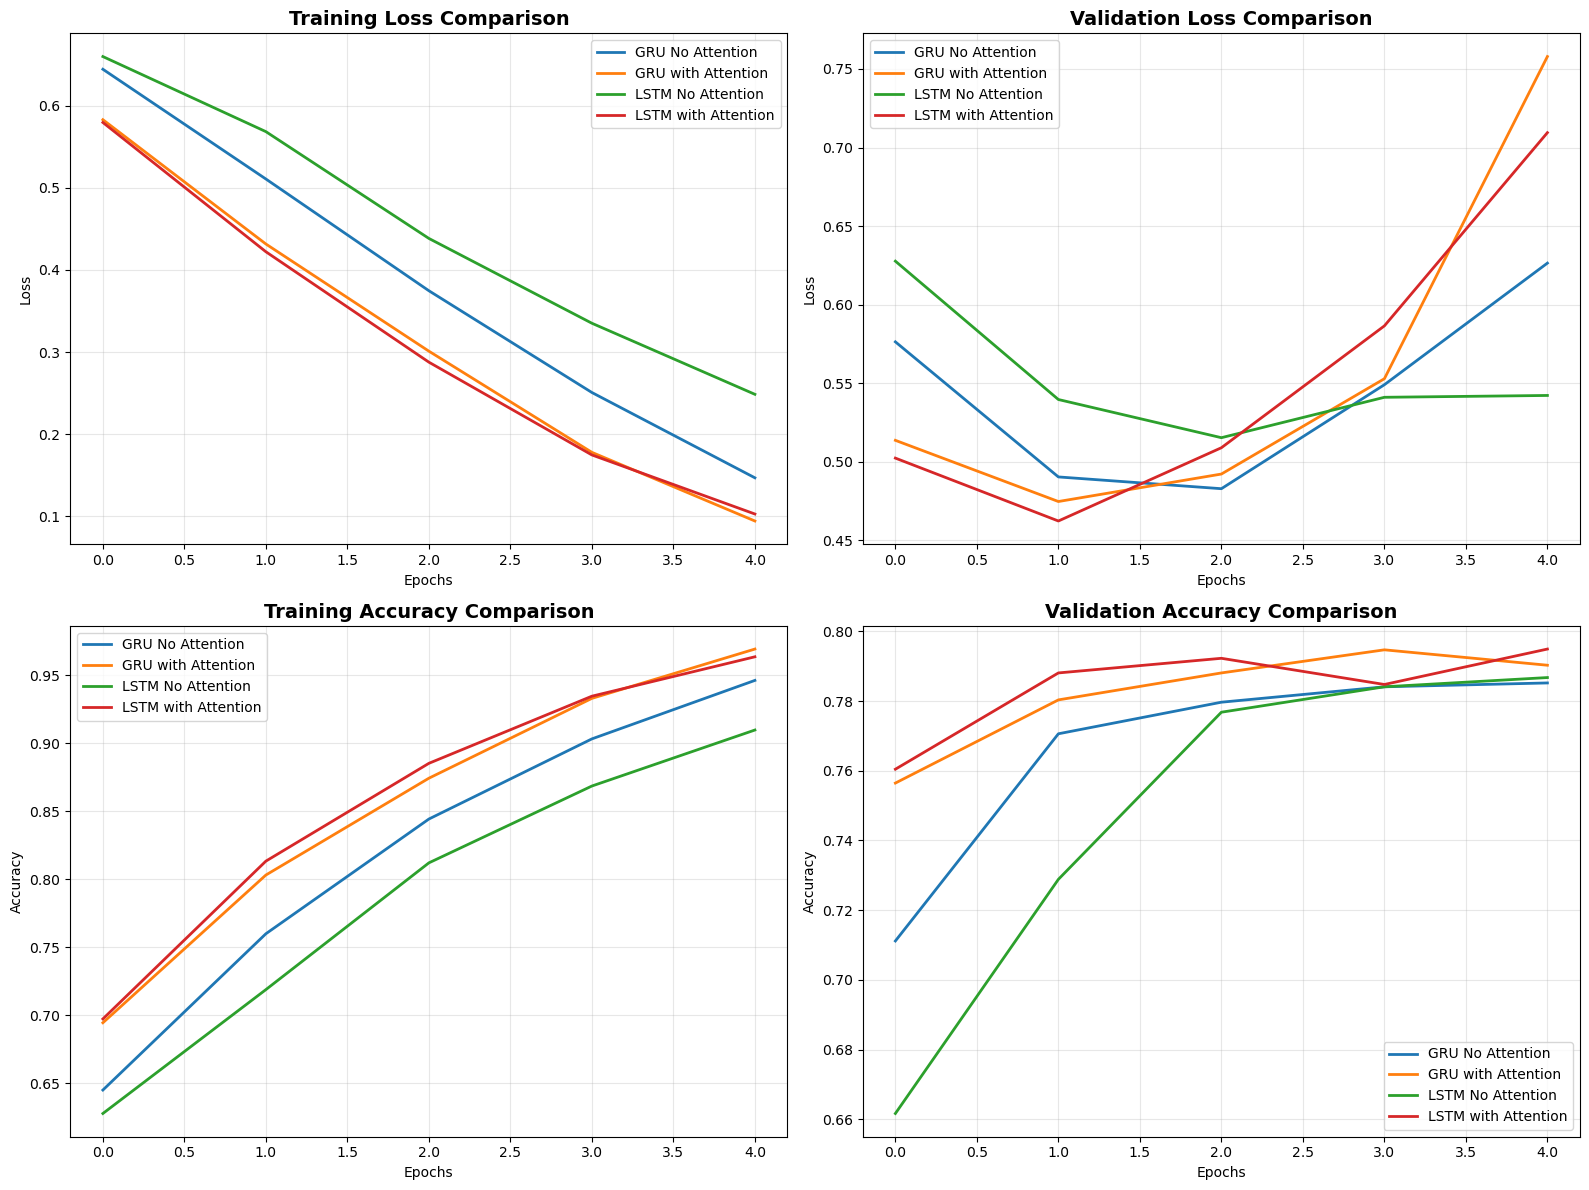


COMPREHENSIVE MODEL COMPARISON SUMMARY

🏆 PERFORMANCE RANKING (by Validation Accuracy):
1. LSTM with Attention: 0.7949 (Best: 0.7949)
2. GRU with Attention: 0.7903 (Best: 0.7947)
3. LSTM No Attention: 0.7867 (Best: 0.7867)
4. GRU No Attention: 0.7852 (Best: 0.7852)

DETAILED METRICS BY MODEL:

📊 GRU No Attention:
   Final Validation Accuracy: 0.7852
   Best Validation Accuracy: 0.7852
   Training Time: 455.7 seconds
   Test Accuracy: 0.7852
   F1 Score: 0.7851
   Precision: 0.7850
   Recall: 0.7852
   Neutral Class - Precision: 0.8299, Recall: 0.8316, F1: 0.8307
   Entails Class - Precision: 0.7075, Recall: 0.7049, F1: 0.7062

📊 GRU with Attention:
   Final Validation Accuracy: 0.7903
   Best Validation Accuracy: 0.7947
   Training Time: 239.7 seconds
   Test Accuracy: 0.7903
   F1 Score: 0.7888
   Precision: 0.7881
   Recall: 0.7903
   Neutral Class - Precision: 0.8232, Recall: 0.8522, F1: 0.8374
   Entails Class - Precision: 0.7275, Recall: 0.6832, F1: 0.7046

📊 LSTM No Attention:
 

In [34]:
# ================================
# Evaluation Metrics Function
# ================================
def calculate_detailed_metrics(model, data_loader, model_name):
    """Calculate comprehensive evaluation metrics"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for premises, hypotheses, labels in data_loader:
            inputs = premises.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    
    # Get per-class metrics
    class_report = classification_report(all_labels, all_predictions, 
                                       target_names=['neutral', 'entails'], 
                                       output_dict=True)
    
    print(f"\n{model_name} - Detailed Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, target_names=['neutral', 'entails']))
    
    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'classification_report': class_report,
        'predictions': all_predictions,
        'true_labels': all_labels
    }

# ================================
# FIXED Training Functions - Ensure they return results
# ================================
def train_gru_no_attention(model, train_loader, val_loader, num_epochs=5, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Initialize tracking lists
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss, train_correct, train_total = 0.0, 0, 0
        
        for premises, hypotheses, labels in train_loader:
            inputs = premises.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_acc = train_correct / train_total
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for premises, hypotheses, labels in val_loader:
                inputs = premises.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    training_time = time.time() - start_time
    
    # RETURN the results dictionary
    return {
        "train_losses": train_losses,
        "train_accs": train_accs,
        "val_losses": val_losses,
        "val_accs": val_accs,
        "training_time": training_time
    }

def train_gru_attention(model, train_loader, val_loader, num_epochs=5, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss, train_correct, train_total = 0.0, 0, 0
        
        for premises, hypotheses, labels in train_loader:
            inputs = premises.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_acc = train_correct / train_total if train_total > 0 else 0.0
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for premises, hypotheses, labels in val_loader:
                inputs = premises.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else 0
        val_acc = val_correct / val_total if val_total > 0 else 0.0
        val_losses.append(avg_val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    training_time = time.time() - start_time
    
    # RETURN the results dictionary
    return {
        "train_losses": train_losses,
        "train_accs": train_accs,
        "val_losses": val_losses,
        "val_accs": val_accs,
        "training_time": training_time
    }

def train_lstm_no_attention(model, train_loader, val_loader, num_epochs=5, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss, train_correct, train_total = 0.0, 0, 0
        
        for premises, hypotheses, labels in train_loader:
            inputs = premises.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_acc = train_correct / train_total if train_total > 0 else 0.0
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for premises, hypotheses, labels in val_loader:
                inputs = premises.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else 0
        val_acc = val_correct / val_total if val_total > 0 else 0.0
        val_losses.append(avg_val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    training_time = time.time() - start_time
    
    # RETURN the results dictionary
    return {
        "train_losses": train_losses,
        "train_accs": train_accs,
        "val_losses": val_losses,
        "val_accs": val_accs,
        "training_time": training_time
    }

def train_lstm_attention(model, train_loader, val_loader, num_epochs=5, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss, train_correct, train_total = 0.0, 0, 0
        
        for premises, hypotheses, labels in train_loader:
            inputs = premises.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_acc = train_correct / train_total
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for premises, hypotheses, labels in val_loader:
                inputs = premises.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    training_time = time.time() - start_time
    
    # RETURN the results dictionary
    return {
        "train_losses": train_losses,
        "train_accs": train_accs,
        "val_losses": val_losses,
        "val_accs": val_accs,
        "training_time": training_time
    }

# ================================
# Main Training and Comparison
# ================================
def train_all_models_comparison():
    """Train all 4 models and compare their performance"""
    
    # Initialize all models with your exact architectures
    models = {
        "GRU No Attention": GRUNoAttentionModel(
            vocab_size=len(word2id), 
            embedding_dim=200, 
            hidden_dim=128,
            dropout=0.3
        ),
        "GRU with Attention": GRUAttentionModel(
            vocab_size=len(word2id), 
            embedding_dim=200, 
            hidden_dim=128,
            dropout=0.3
        ),
        "LSTM No Attention": LSTMNoAttentionModel(
            vocab_size=len(word2id), 
            embedding_dim=200, 
            hidden_dim=128,
            dropout=0.3
        ),
        "LSTM with Attention": LSTMAttentionModel(
            vocab_size=len(word2id), 
            embedding_dim=200, 
            hidden_dim=128,
            dropout=0.3
        )
    }
    
    results = {}
    detailed_metrics = {}
    
    # Train each model
    for name, model in models.items():
        print(f"\n{'='*60}")
        print(f"TRAINING {name}")
        print(f"{'='*60}")
        
        # Train the model using your exact training functions
        if "GRU" in name and "No Attention" in name:
            result = train_gru_no_attention(model, train_loader, val_loader, num_epochs=5, lr=0.001)
        elif "GRU" in name and "Attention" in name:
            result = train_gru_attention(model, train_loader, val_loader, num_epochs=5, lr=0.001)
        elif "LSTM" in name and "No Attention" in name:
            result = train_lstm_no_attention(model, train_loader, val_loader, num_epochs=5, lr=0.001)
        else:
            result = train_lstm_attention(model, train_loader, val_loader, num_epochs=5, lr=0.001)
        
        # Check if result is not None before storing
        if result is not None:
            results[name] = result
            # Calculate detailed metrics
            detailed_metrics[name] = calculate_detailed_metrics(model, val_loader, name)
        else:
            print(f"⚠️ Warning: {name} training returned None result!")
    
    return results, detailed_metrics

# ================================
# Visualization (with error handling)
# ================================
def plot_comparison_results(results):
    """Create comparison plots for all models"""
    if not results:
        print("❌ No results to plot!")
        return
        
    plt.figure(figsize=(16, 12))
    
    # Training loss curves
    plt.subplot(2, 2, 1)
    for name, result in results.items():
        if result and "train_losses" in result:
            plt.plot(result["train_losses"], label=name, linewidth=2)
    plt.title("Training Loss Comparison", fontsize=14, fontweight='bold')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Validation loss curves
    plt.subplot(2, 2, 2)
    for name, result in results.items():
        if result and "val_losses" in result:
            plt.plot(result["val_losses"], label=name, linewidth=2)
    plt.title("Validation Loss Comparison", fontsize=14, fontweight='bold')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Training accuracy curves
    plt.subplot(2, 2, 3)
    for name, result in results.items():
        if result and "train_accs" in result:
            plt.plot(result["train_accs"], label=name, linewidth=2)
    plt.title("Training Accuracy Comparison", fontsize=14, fontweight='bold')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Validation accuracy curves
    plt.subplot(2, 2, 4)
    for name, result in results.items():
        if result and "val_accs" in result:
            plt.plot(result["val_accs"], label=name, linewidth=2)
    plt.title("Validation Accuracy Comparison", fontsize=14, fontweight='bold')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ================================
# Final Results Summary (with error handling)
# ================================
def print_comprehensive_summary(results, detailed_metrics):
    """Print comprehensive comparison of all models"""
    if not results:
        print("❌ No results to summarize!")
        return
        
    print("\n" + "="*80)
    print("COMPREHENSIVE MODEL COMPARISON SUMMARY")
    print("="*80)
    
    # Filter out None results for ranking
    valid_results = {name: result for name, result in results.items() if result is not None}
    
    if not valid_results:
        print("❌ No valid results to rank!")
        return
    
    # Performance ranking
    ranking = sorted(valid_results.items(), key=lambda x: x[1]["val_accs"][-1], reverse=True)
    
    print("\n🏆 PERFORMANCE RANKING (by Validation Accuracy):")
    for i, (name, result) in enumerate(ranking, 1):
        final_val_acc = result["val_accs"][-1]
        best_val_acc = max(result["val_accs"])
        print(f"{i}. {name}: {final_val_acc:.4f} (Best: {best_val_acc:.4f})")
    
    print("\n" + "="*80)
    print("DETAILED METRICS BY MODEL:")
    print("="*80)
    
    for name in results.keys():
        if name in detailed_metrics and name in results and results[name] is not None:
            metrics = detailed_metrics[name]
            result = results[name]
            
            print(f"\n📊 {name}:")
            print(f"   Final Validation Accuracy: {result['val_accs'][-1]:.4f}")
            print(f"   Best Validation Accuracy: {max(result['val_accs']):.4f}")
            print(f"   Training Time: {result['training_time']:.1f} seconds")
            print(f"   Test Accuracy: {metrics['accuracy']:.4f}")
            print(f"   F1 Score: {metrics['f1_score']:.4f}")
            print(f"   Precision: {metrics['precision']:.4f}")
            print(f"   Recall: {metrics['recall']:.4f}")
            
            # Show class-wise performance
            class_report = metrics['classification_report']
            print(f"   Neutral Class - Precision: {class_report['neutral']['precision']:.4f}, "
                  f"Recall: {class_report['neutral']['recall']:.4f}, "
                  f"F1: {class_report['neutral']['f1-score']:.4f}")
            print(f"   Entails Class - Precision: {class_report['entails']['precision']:.4f}, "
                  f"Recall: {class_report['entails']['recall']:.4f}, "
                  f"F1: {class_report['entails']['f1-score']:.4f}")

# ================================
# Ablation Study (with error handling)
# ================================
def perform_ablation_analysis(results):
    """Analyze the impact of attention mechanisms"""
    if not results:
        print("❌ No results for ablation analysis!")
        return
        
    print("\n" + "="*60)
    print("ABLATION ANALYSIS: ATTENTION MECHANISM IMPACT")
    print("="*60)
    
    # Check if required models exist and have results
    required_models = ["GRU with Attention", "GRU No Attention", "LSTM with Attention", "LSTM No Attention"]
    missing_models = [model for model in required_models if model not in results or results[model] is None]
    
    if missing_models:
        print(f"⚠️ Missing models for ablation analysis: {missing_models}")
        return
    
    # GRU comparison
    gru_with_acc = results["GRU with Attention"]["val_accs"][-1]
    gru_without_acc = results["GRU No Attention"]["val_accs"][-1]
    gru_improvement = gru_with_acc - gru_without_acc
    
    # LSTM comparison  
    lstm_with_acc = results["LSTM with Attention"]["val_accs"][-1]
    lstm_without_acc = results["LSTM No Attention"]["val_accs"][-1]
    lstm_improvement = lstm_with_acc - lstm_without_acc
    
    print(f"GRU Attention Impact: {gru_improvement:+.4f} "
          f"({gru_without_acc:.4f} → {gru_with_acc:.4f})")
    print(f"LSTM Attention Impact: {lstm_improvement:+.4f} "
          f"({lstm_without_acc:.4f} → {lstm_with_acc:.4f})")
    
    # Overall best architecture
    best_model = max(results.items(), key=lambda x: x[1]["val_accs"][-1])
    print(f"\n🎯 Best Overall Architecture: {best_model[0]} "
          f"(Val Acc: {best_model[1]['val_accs'][-1]:.4f})")

# ================================
# Run the complete comparison
# ================================
print("🚀 STARTING COMPREHENSIVE MODEL COMPARISON")
print("This will train all 4 models and generate comparison plots and metrics...")

# Train all models and get results
results, detailed_metrics = train_all_models_comparison()

# Generate comparison plots
plot_comparison_results(results)

# Print comprehensive summary
print_comprehensive_summary(results, detailed_metrics)

# Perform ablation analysis
perform_ablation_analysis(results)

print("\n✅ Model comparison completed!")

# MODELS with Fast Text

### Load FastText

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# ================================
# Helper Function to Load FastText Embeddings
# ================================
def create_embedding_matrix(fast_text_model, word2id, embedding_dim=200):
    """Create embedding matrix from FastText model"""
    vocab_size = len(word2id)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    for word, idx in word2id.items():
        if word in fast_text_model.wv:
            embedding_matrix[idx] = fast_text_model.wv[word]
        else:
            embedding_matrix[idx] = np.random.normal(0, 0.1, embedding_dim)
    
    return torch.FloatTensor(embedding_matrix)

#### Call Command

In [ ]:
# ================================
# USAGE: Train All 4 Models with FastText
# ================================
print("="*60)
print("CREATING FASTTEXT EMBEDDING MATRIX")
print("="*60)

# Create embedding matrix from FastText (ONCE)
embedding_matrix = create_embedding_matrix(fast_text_model, word2id, embedding_dim=200)
print(f"✓ Embedding matrix created: {embedding_matrix.shape}")


### GRU Model | NO ATTENTION

No attention, use FastText

In [58]:
# ================================
# GRU No Attention with FastText
# ================================
class GRUNoAttentionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, pretrained_embeddings=None, 
                 output_dim=2, dropout=0.3, freeze_embeddings=False):
        super(GRUNoAttentionModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        if pretrained_embeddings is not None:
            self.embedding.weight = nn.Parameter(pretrained_embeddings)
            if freeze_embeddings:
                self.embedding.weight.requires_grad = False
        
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, 
                         num_layers=2, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    
    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        last_hidden = gru_out[:, -1, :]
        last_hidden = self.dropout(last_hidden)
        return self.fc(last_hidden)

def train_gru_no_attention(model, train_loader, val_loader, num_epochs=5, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss, train_correct, train_total = 0.0, 0, 0
        
        for premises, hypotheses, labels in train_loader:
            inputs = premises.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_acc = train_correct / train_total
        
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for premises, hypotheses, labels in val_loader:
                inputs = premises.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

#### Call Command

In [ ]:
# ================================
# 1. GRU No Attention
# ================================
print("\n" + "="*60)
print("TRAINING GRU NO ATTENTION WITH FASTTEXT")
print("="*60)

model_gru_no_attn = GRUNoAttentionModel(
    vocab_size=len(word2id),
    embedding_dim=200,
    hidden_dim=128,
    pretrained_embeddings=embedding_matrix,
    freeze_embeddings=False
)
train_gru_no_attention(model_gru_no_attn, train_loader, val_loader, num_epochs=5, lr=0.001)

Model Architecture:
Embedding Dimension: 200 (matches FastText)

Hidden Dimension: 128

Dropout: 0.3

Optimizer: Adam (lr=0.001)

Attention: ❌ None

Loss Function: CrossEntropyLoss

Component Explanations:
Embedding (200-dim): Converts word indices to dense vectors using pre-trained FastText embeddings

Hidden (128-dim): 128 units in each GRU direction → 256 total features (bidirectional)

Dropout (0.3): 30% neuron dropout for regularization to prevent overfitting

Adam Optimizer: Adaptive learning rate optimizer that works well for RNNs

CrossEntropyLoss: Standard for classification tasks, handles softmax + negative log likelihood

Architecture: 2-layer bidirectional GRU → takes last hidden state → linear classification



### GRU Model with Attention

Use FastText

In [59]:
# ================================
# GRU with Attention and FastText
# ================================
class GRUAttentionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, pretrained_embeddings=None,
                 output_dim=2, dropout=0.4, freeze_embeddings=False):
        super(GRUAttentionModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        if pretrained_embeddings is not None:
            self.embedding.weight = nn.Parameter(pretrained_embeddings)
            if freeze_embeddings:
                self.embedding.weight.requires_grad = False
        
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, 
                         num_layers=1)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    
    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        attn_weights = torch.softmax(self.attention(gru_out), dim=1)
        context = torch.sum(attn_weights * gru_out, dim=1)
        context = self.dropout(context)
        return self.fc(context)

def train_gru_attention(model, train_loader, val_loader, num_epochs=5, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss, train_correct, train_total = 0.0, 0, 0
        
        for premises, hypotheses, labels in train_loader:
            inputs = premises.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_acc = train_correct / train_total if train_total > 0 else 0.0
        
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for premises, hypotheses, labels in val_loader:
                inputs = premises.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        avg_val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else 0
        val_acc = val_correct / val_total if val_total > 0 else 0.0
        
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

#### Call Command

In [ ]:
# ================================
# 2. GRU with Attention
# ================================
print("\n" + "="*60)
print("TRAINING GRU WITH ATTENTION AND FASTTEXT")
print("="*60)

model_gru_attn = GRUAttentionModel(
    vocab_size=len(word2id),
    embedding_dim=200,
    hidden_dim=128,
    pretrained_embeddings=embedding_matrix,
    freeze_embeddings=False
)
train_gru_attention(model_gru_attn, train_loader, val_loader, num_epochs=5, lr=0.001)

Model Architecture:
Embedding Dimension: 200 (matches FastText)

Hidden Dimension: 128

Dropout: 0.4

Optimizer: Adam (lr=0.001)

Attention: ✅ Content-based Attention

Loss Function: CrossEntropyLoss

Component Explanations:
Embedding (200-dim): FastText word embeddings (same as all models)

Hidden (128-dim): 128 GRU units per direction → 256 total features

Dropout (0.4): Higher dropout (40%) - likely because attention adds complexity

Attention Mechanism:

Type: Content-based/self-attention

Implementation: Linear layer → softmax to weight sequence elements

Purpose: Weights important words in the sequence dynamically

Architecture: Single-layer BiGRU → attention-weighted context vector → classification

### LSTM Model | NO ATTENTION

No attention, use FastText

In [60]:

# ================================
# LSTM No Attention with FastText
# ================================
class LSTMNoAttentionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, pretrained_embeddings=None,
                 output_dim=2, dropout=0.4, freeze_embeddings=False):
        super(LSTMNoAttentionModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        if pretrained_embeddings is not None:
            self.embedding.weight = nn.Parameter(pretrained_embeddings)
            if freeze_embeddings:
                self.embedding.weight.requires_grad = False
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, 
                           num_layers=1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        last_hidden = lstm_out[:, -1, :]
        last_hidden = self.dropout(last_hidden)
        return self.fc(last_hidden)

def train_lstm_no_attention(model, train_loader, val_loader, num_epochs=5, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss, train_correct, train_total = 0.0, 0, 0
        
        for premises, hypotheses, labels in train_loader:
            inputs = premises.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_acc = train_correct / train_total if train_total > 0 else 0.0
        
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for premises, hypotheses, labels in val_loader:
                inputs = premises.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        avg_val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else 0
        val_acc = val_correct / val_total if val_total > 0 else 0.0
        
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

#### Call Command

In [ ]:
# ================================
# 3. LSTM No Attention
# ================================
print("\n" + "="*60)
print("TRAINING LSTM NO ATTENTION WITH FASTTEXT")
print("="*60)

model_lstm_no_attn = LSTMNoAttentionModel(
    vocab_size=len(word2id),
    embedding_dim=200,
    hidden_dim=128,
    pretrained_embeddings=embedding_matrix,
    freeze_embeddings=False
)
train_lstm_no_attention(model_lstm_no_attn, train_loader, val_loader, num_epochs=5, lr=0.001)

Model Architecture:
Embedding Dimension: 200 (matches FastText)

Hidden Dimension: 128

Dropout: 0.4

Optimizer: Adam (lr=0.001)

Attention: ❌ None

Loss Function: CrossEntropyLoss

Component Explanations:
Embedding (200-dim): FastText embeddings (consistent across all models)

Hidden (128-dim): 128 LSTM cells per direction → 256 total output features

Dropout (0.4): 40% dropout - higher than GRU no-attention, possibly for LSTM regularization

LSTM vs GRU: LSTM has separate forget/input/output gates vs GRU's update/reset gates

Architecture: Single-layer BiLSTM → last hidden state → linear classifier

### LSTM Model with Attention

Use FastText

In [61]:
# ================================
# LSTM with Attention and FastText
# ================================
class LSTMAttentionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, pretrained_embeddings=None,
                 output_dim=2, dropout=0.3, freeze_embeddings=False):
        super(LSTMAttentionModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        if pretrained_embeddings is not None:
            self.embedding.weight = nn.Parameter(pretrained_embeddings)
            if freeze_embeddings:
                self.embedding.weight.requires_grad = False
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, 
                           num_layers=2, dropout=dropout)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        context = self.dropout(context)
        return self.fc(context)

def train_lstm_attention(model, train_loader, val_loader, num_epochs=5, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss, train_correct, train_total = 0.0, 0, 0
        
        for premises, hypotheses, labels in train_loader:
            inputs = premises.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_acc = train_correct / train_total
        
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for premises, hypotheses, labels in val_loader:
                inputs = premises.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

#### Call Command

In [62]:
# ================================
# 4. LSTM with Attention
# ================================
print("\n" + "="*60)
print("TRAINING LSTM WITH ATTENTION AND FASTTEXT")
print("="*60)

model_lstm_attn = LSTMAttentionModel(
    vocab_size=len(word2id),
    embedding_dim=200,
    hidden_dim=128,
    pretrained_embeddings=embedding_matrix,
    freeze_embeddings=False
)
train_lstm_attention(model_lstm_attn, train_loader, val_loader, num_epochs=5, lr=0.001)

print("\n✅ All 4 models trained successfully with FastText embeddings!")

CREATING FASTTEXT EMBEDDING MATRIX
✓ Embedding matrix created: torch.Size([21790, 200])

TRAINING GRU NO ATTENTION WITH FASTTEXT
Epoch 1/5 | Train Loss: 0.6446 | Train Acc: 0.6451 | Val Loss: 0.5571 | Val Acc: 0.7238
Epoch 2/5 | Train Loss: 0.4677 | Train Acc: 0.7870 | Val Loss: 0.4723 | Val Acc: 0.7799
Epoch 3/5 | Train Loss: 0.3134 | Train Acc: 0.8717 | Val Loss: 0.4670 | Val Acc: 0.8022
Epoch 4/5 | Train Loss: 0.2036 | Train Acc: 0.9225 | Val Loss: 0.5294 | Val Acc: 0.7956
Epoch 5/5 | Train Loss: 0.1240 | Train Acc: 0.9568 | Val Loss: 0.7040 | Val Acc: 0.7854

TRAINING GRU WITH ATTENTION AND FASTTEXT
Epoch 1/5 | Train Loss: 0.2838 | Train Acc: 0.8754 | Val Loss: 0.5923 | Val Acc: 0.7909
Epoch 2/5 | Train Loss: 0.1439 | Train Acc: 0.9483 | Val Loss: 0.6436 | Val Acc: 0.7799
Epoch 3/5 | Train Loss: 0.0923 | Train Acc: 0.9688 | Val Loss: 0.7317 | Val Acc: 0.7834
Epoch 4/5 | Train Loss: 0.0640 | Train Acc: 0.9784 | Val Loss: 0.8994 | Val Acc: 0.7757
Epoch 5/5 | Train Loss: 0.0494 | Trai

Model Architecture:
Embedding Dimension: 200 (matches FastText)

Hidden Dimension: 128

Dropout: 0.3

Optimizer: Adam (lr=0.001)

Attention: ✅ Content-based Attention

Loss Function: CrossEntropyLoss

Component Explanations:
Embedding (200-dim): FastText word vectors

Hidden (128-dim): 128 LSTM units per direction → 256-dimensional representations

Dropout (0.3): 30% dropout (lower than LSTM no-attention variant)

Attention Mechanism:

Type: Same content-based attention as GRU attention model

Process: Learns importance weights for each time step

Architecture: 2-layer BiLSTM → attention context vector → classification

## Evaluate all 4 Models FastText

CREATING FASTTEXT EMBEDDING MATRIX
✓ Embedding matrix created: torch.Size([21790, 200])

🚀 STARTING COMPREHENSIVE MODEL COMPARISON WITH FASTTEXT
This will train all 4 models with FastText embeddings...

TRAINING GRU No Attention WITH FASTTEXT EMBEDDINGS
Epoch 1/5 | Train Loss: 0.6552 | Train Acc: 0.6337 | Val Loss: 0.5805 | Val Acc: 0.7032
Epoch 2/5 | Train Loss: 0.4770 | Train Acc: 0.7771 | Val Loss: 0.4543 | Val Acc: 0.7859
Epoch 3/5 | Train Loss: 0.3091 | Train Acc: 0.8723 | Val Loss: 0.4653 | Val Acc: 0.8024
Epoch 4/5 | Train Loss: 0.1930 | Train Acc: 0.9240 | Val Loss: 0.5431 | Val Acc: 0.7912
Epoch 5/5 | Train Loss: 0.1154 | Train Acc: 0.9585 | Val Loss: 0.6559 | Val Acc: 0.7940

GRU No Attention - Detailed Evaluation Metrics:
Accuracy: 0.7940
F1 Score: 0.7903
Precision: 0.7911
Recall: 0.7940

Classification Report:
              precision    recall  f1-score   support

     neutral       0.81      0.88      0.84      2868
     entails       0.75      0.65      0.70      1657

  

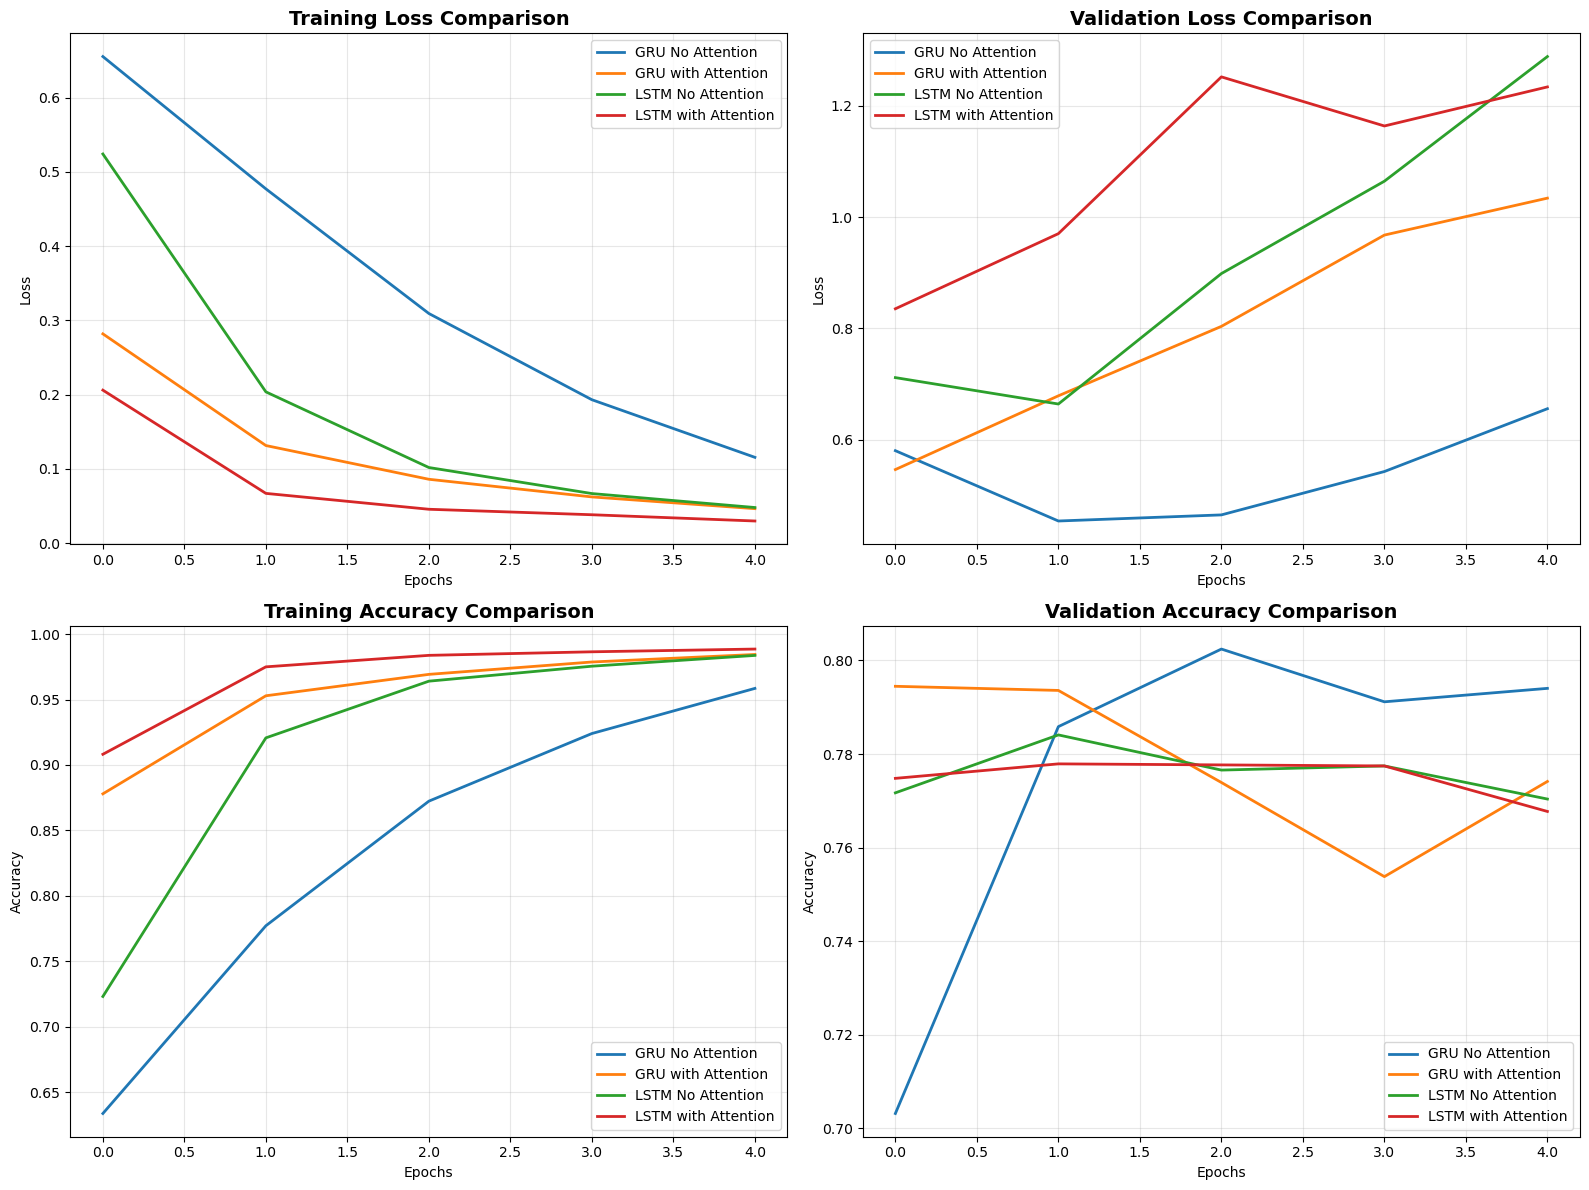


COMPREHENSIVE MODEL COMPARISON SUMMARY (WITH FASTTEXT)

🏆 PERFORMANCE RANKING (by Validation Accuracy):
1. GRU No Attention: 0.7940 (Best: 0.8024)
2. GRU with Attention: 0.7741 (Best: 0.7945)
3. LSTM No Attention: 0.7704 (Best: 0.7841)
4. LSTM with Attention: 0.7677 (Best: 0.7779)

DETAILED METRICS BY MODEL:

📊 GRU No Attention:
   Final Validation Accuracy: 0.7940
   Best Validation Accuracy: 0.8024
   Training Time: 544.2 seconds
   Test Accuracy: 0.7940
   F1 Score: 0.7903
   Precision: 0.7911
   Recall: 0.7940
   Neutral Class - Precision: 0.8123, Recall: 0.8780, F1: 0.8438
   Entails Class - Precision: 0.7544, Recall: 0.6488, F1: 0.6976

📊 GRU with Attention:
   Final Validation Accuracy: 0.7741
   Best Validation Accuracy: 0.7945
   Training Time: 273.5 seconds
   Test Accuracy: 0.7741
   F1 Score: 0.7754
   Precision: 0.7774
   Recall: 0.7741
   Neutral Class - Precision: 0.8330, Recall: 0.8051, F1: 0.8188
   Entails Class - Precision: 0.6811, Recall: 0.7206, F1: 0.7003

📊 LSTM

In [63]:
import torch
import time
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# ================================
# Evaluation Metrics Function
# ================================
def calculate_detailed_metrics(model, data_loader, model_name):
    """Calculate comprehensive evaluation metrics"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for premises, hypotheses, labels in data_loader:
            inputs = premises.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    
    # Get per-class metrics
    class_report = classification_report(all_labels, all_predictions, 
                                       target_names=['neutral', 'entails'], 
                                       output_dict=True)
    
    print(f"\n{model_name} - Detailed Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, target_names=['neutral', 'entails']))
    
    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'classification_report': class_report,
        'predictions': all_predictions,
        'true_labels': all_labels
    }

# ================================
# Training Functions with Return Values
# ================================
def train_gru_no_attention(model, train_loader, val_loader, num_epochs=5, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss, train_correct, train_total = 0.0, 0, 0
        
        for premises, hypotheses, labels in train_loader:
            inputs = premises.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_acc = train_correct / train_total
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for premises, hypotheses, labels in val_loader:
                inputs = premises.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    training_time = time.time() - start_time
    
    return {
        "train_losses": train_losses,
        "train_accs": train_accs,
        "val_losses": val_losses,
        "val_accs": val_accs,
        "training_time": training_time
    }

def train_gru_attention(model, train_loader, val_loader, num_epochs=5, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss, train_correct, train_total = 0.0, 0, 0
        
        for premises, hypotheses, labels in train_loader:
            inputs = premises.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_acc = train_correct / train_total if train_total > 0 else 0.0
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for premises, hypotheses, labels in val_loader:
                inputs = premises.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else 0
        val_acc = val_correct / val_total if val_total > 0 else 0.0
        val_losses.append(avg_val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    training_time = time.time() - start_time
    
    return {
        "train_losses": train_losses,
        "train_accs": train_accs,
        "val_losses": val_losses,
        "val_accs": val_accs,
        "training_time": training_time
    }

def train_lstm_no_attention(model, train_loader, val_loader, num_epochs=5, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss, train_correct, train_total = 0.0, 0, 0
        
        for premises, hypotheses, labels in train_loader:
            inputs = premises.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_acc = train_correct / train_total if train_total > 0 else 0.0
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for premises, hypotheses, labels in val_loader:
                inputs = premises.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else 0
        val_acc = val_correct / val_total if val_total > 0 else 0.0
        val_losses.append(avg_val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    training_time = time.time() - start_time
    
    return {
        "train_losses": train_losses,
        "train_accs": train_accs,
        "val_losses": val_losses,
        "val_accs": val_accs,
        "training_time": training_time
    }

def train_lstm_attention(model, train_loader, val_loader, num_epochs=5, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss, train_correct, train_total = 0.0, 0, 0
        
        for premises, hypotheses, labels in train_loader:
            inputs = premises.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_acc = train_correct / train_total
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for premises, hypotheses, labels in val_loader:
                inputs = premises.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    training_time = time.time() - start_time
    
    return {
        "train_losses": train_losses,
        "train_accs": train_accs,
        "val_losses": val_losses,
        "val_accs": val_accs,
        "training_time": training_time
    }

# ================================
# Main Training and Comparison WITH FASTTEXT
# ================================
def train_all_models_comparison(embedding_matrix, freeze_embeddings=False):
    """Train all 4 models with FastText embeddings and compare their performance"""
    
    # Initialize all models with FastText embeddings
    models = {
        "GRU No Attention": GRUNoAttentionModel(
            vocab_size=len(word2id), 
            embedding_dim=200, 
            hidden_dim=128,
            pretrained_embeddings=embedding_matrix,
            dropout=0.3,
            freeze_embeddings=freeze_embeddings
        ),
        "GRU with Attention": GRUAttentionModel(
            vocab_size=len(word2id), 
            embedding_dim=200, 
            hidden_dim=128,
            pretrained_embeddings=embedding_matrix,
            dropout=0.4,
            freeze_embeddings=freeze_embeddings
        ),
        "LSTM No Attention": LSTMNoAttentionModel(
            vocab_size=len(word2id), 
            embedding_dim=200, 
            hidden_dim=128,
            pretrained_embeddings=embedding_matrix,
            dropout=0.4,
            freeze_embeddings=freeze_embeddings
        ),
        "LSTM with Attention": LSTMAttentionModel(
            vocab_size=len(word2id), 
            embedding_dim=200, 
            hidden_dim=128,
            pretrained_embeddings=embedding_matrix,
            dropout=0.3,
            freeze_embeddings=freeze_embeddings
        )
    }
    
    results = {}
    detailed_metrics = {}
    
    # Train each model
    for name, model in models.items():
        print(f"\n{'='*60}")
        print(f"TRAINING {name} WITH FASTTEXT EMBEDDINGS")
        print(f"{'='*60}")
        
        # Train the model using your exact training functions
        if "GRU" in name and "No Attention" in name:
            result = train_gru_no_attention(model, train_loader, val_loader, num_epochs=5, lr=0.001)
        elif "GRU" in name and "Attention" in name:
            result = train_gru_attention(model, train_loader, val_loader, num_epochs=5, lr=0.001)
        elif "LSTM" in name and "No Attention" in name:
            result = train_lstm_no_attention(model, train_loader, val_loader, num_epochs=5, lr=0.001)
        else:
            result = train_lstm_attention(model, train_loader, val_loader, num_epochs=5, lr=0.001)
        
        # Check if result is not None before storing
        if result is not None:
            results[name] = result
            # Calculate detailed metrics
            detailed_metrics[name] = calculate_detailed_metrics(model, val_loader, name)
        else:
            print(f"⚠️ Warning: {name} training returned None result!")
    
    return results, detailed_metrics

# ================================
# Visualization
# ================================
def plot_comparison_results(results):
    """Create comparison plots for all models"""
    if not results:
        print("❌ No results to plot!")
        return
        
    plt.figure(figsize=(16, 12))
    
    # Training loss curves
    plt.subplot(2, 2, 1)
    for name, result in results.items():
        if result and "train_losses" in result:
            plt.plot(result["train_losses"], label=name, linewidth=2)
    plt.title("Training Loss Comparison", fontsize=14, fontweight='bold')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Validation loss curves
    plt.subplot(2, 2, 2)
    for name, result in results.items():
        if result and "val_losses" in result:
            plt.plot(result["val_losses"], label=name, linewidth=2)
    plt.title("Validation Loss Comparison", fontsize=14, fontweight='bold')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Training accuracy curves
    plt.subplot(2, 2, 3)
    for name, result in results.items():
        if result and "train_accs" in result:
            plt.plot(result["train_accs"], label=name, linewidth=2)
    plt.title("Training Accuracy Comparison", fontsize=14, fontweight='bold')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Validation accuracy curves
    plt.subplot(2, 2, 4)
    for name, result in results.items():
        if result and "val_accs" in result:
            plt.plot(result["val_accs"], label=name, linewidth=2)
    plt.title("Validation Accuracy Comparison", fontsize=14, fontweight='bold')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ================================
# Final Results Summary
# ================================
def print_comprehensive_summary(results, detailed_metrics):
    """Print comprehensive comparison of all models"""
    if not results:
        print("❌ No results to summarize!")
        return
        
    print("\n" + "="*80)
    print("COMPREHENSIVE MODEL COMPARISON SUMMARY (WITH FASTTEXT)")
    print("="*80)
    
    # Filter out None results for ranking
    valid_results = {name: result for name, result in results.items() if result is not None}
    
    if not valid_results:
        print("❌ No valid results to rank!")
        return
    
    # Performance ranking
    ranking = sorted(valid_results.items(), key=lambda x: x[1]["val_accs"][-1], reverse=True)
    
    print("\n🏆 PERFORMANCE RANKING (by Validation Accuracy):")
    for i, (name, result) in enumerate(ranking, 1):
        final_val_acc = result["val_accs"][-1]
        best_val_acc = max(result["val_accs"])
        print(f"{i}. {name}: {final_val_acc:.4f} (Best: {best_val_acc:.4f})")
    
    print("\n" + "="*80)
    print("DETAILED METRICS BY MODEL:")
    print("="*80)
    
    for name in results.keys():
        if name in detailed_metrics and name in results and results[name] is not None:
            metrics = detailed_metrics[name]
            result = results[name]
            
            print(f"\n📊 {name}:")
            print(f"   Final Validation Accuracy: {result['val_accs'][-1]:.4f}")
            print(f"   Best Validation Accuracy: {max(result['val_accs']):.4f}")
            print(f"   Training Time: {result['training_time']:.1f} seconds")
            print(f"   Test Accuracy: {metrics['accuracy']:.4f}")
            print(f"   F1 Score: {metrics['f1_score']:.4f}")
            print(f"   Precision: {metrics['precision']:.4f}")
            print(f"   Recall: {metrics['recall']:.4f}")
            
            # Show class-wise performance
            class_report = metrics['classification_report']
            print(f"   Neutral Class - Precision: {class_report['neutral']['precision']:.4f}, "
                  f"Recall: {class_report['neutral']['recall']:.4f}, "
                  f"F1: {class_report['neutral']['f1-score']:.4f}")
            print(f"   Entails Class - Precision: {class_report['entails']['precision']:.4f}, "
                  f"Recall: {class_report['entails']['recall']:.4f}, "
                  f"F1: {class_report['entails']['f1-score']:.4f}")

# ================================
# Ablation Study
# ================================
def perform_ablation_analysis(results):
    """Analyze the impact of attention mechanisms"""
    if not results:
        print("❌ No results for ablation analysis!")
        return
        
    print("\n" + "="*60)
    print("ABLATION ANALYSIS: ATTENTION MECHANISM IMPACT")
    print("="*60)
    
    # Check if required models exist and have results
    required_models = ["GRU with Attention", "GRU No Attention", "LSTM with Attention", "LSTM No Attention"]
    missing_models = [model for model in required_models if model not in results or results[model] is None]
    
    if missing_models:
        print(f"⚠️ Missing models for ablation analysis: {missing_models}")
        return
    
    # GRU comparison
    gru_with_acc = results["GRU with Attention"]["val_accs"][-1]
    gru_without_acc = results["GRU No Attention"]["val_accs"][-1]
    gru_improvement = gru_with_acc - gru_without_acc
    
    # LSTM comparison  
    lstm_with_acc = results["LSTM with Attention"]["val_accs"][-1]
    lstm_without_acc = results["LSTM No Attention"]["val_accs"][-1]
    lstm_improvement = lstm_with_acc - lstm_without_acc
    
    print(f"GRU Attention Impact: {gru_improvement:+.4f} "
          f"({gru_without_acc:.4f} → {gru_with_acc:.4f})")
    print(f"LSTM Attention Impact: {lstm_improvement:+.4f} "
          f"({lstm_without_acc:.4f} → {lstm_with_acc:.4f})")
    
    # Overall best architecture
    best_model = max(results.items(), key=lambda x: x[1]["val_accs"][-1])
    print(f"\n🎯 Best Overall Architecture: {best_model[0]} "
          f"(Val Acc: {best_model[1]['val_accs'][-1]:.4f})")

# ================================
# Run the complete comparison WITH FASTTEXT
# ================================
print("="*60)
print("CREATING FASTTEXT EMBEDDING MATRIX")
print("="*60)

# Create embedding matrix from FastText
embedding_matrix = create_embedding_matrix(fast_text_model, word2id, embedding_dim=200)
print(f"✓ Embedding matrix created: {embedding_matrix.shape}")

print("\n🚀 STARTING COMPREHENSIVE MODEL COMPARISON WITH FASTTEXT")
print("This will train all 4 models with FastText embeddings...")

# Train all models and get results (with FastText embeddings, fine-tuning allowed)
results, detailed_metrics = train_all_models_comparison(embedding_matrix, freeze_embeddings=False)

# Generate comparison plots
plot_comparison_results(results)

# Print comprehensive summary
print_comprehensive_summary(results, detailed_metrics)

# Perform ablation analysis
perform_ablation_analysis(results)

print("\n✅ Model comparison with FastText embeddings completed!")

# Hyperparameter Tuning (OWN EMBEDDING)

### HIDE

### GRU ATTENTION

In [38]:
# ================================
# CHUNK 2: GRU WITH ATTENTION TUNING
# ================================

import optuna
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import pickle
import os
import pandas as pd
from sklearn.metrics import accuracy_score

def objective_gru_attention(trial, train_loader, val_loader):
    """Objective function for GRU with Attention hyperparameter optimization"""
    
    # Suggest hyperparameters
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256])
    dropout = trial.suggest_float('dropout', 0.2, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    num_layers = trial.suggest_categorical('num_layers', [1, 2])
    
    # Create model with suggested hyperparameters
    model = GRUAttentionModel(
        vocab_size=len(word2id),
        embedding_dim=200,
        hidden_dim=hidden_dim,
        dropout=dropout
    )
    
    # Train with fewer epochs for tuning efficiency
    result = train_gru_attention(model, train_loader, val_loader, num_epochs=3, lr=learning_rate)
    
    # Return best validation accuracy as objective to maximize
    best_val_acc = max(result["val_accs"])
    
    # For research insights, also track training dynamics
    trial.set_user_attr('train_losses', result["train_losses"])
    trial.set_user_attr('val_losses', result["val_losses"])
    trial.set_user_attr('train_accs', result["train_accs"])
    trial.set_user_attr('final_train_acc', result["train_accs"][-1])
    
    return best_val_acc

def save_study(study, model_name):
    """Save study results to disk"""
    filename = f"optuna_study_{model_name.replace(' ', '_')}.pkl"
    with open(filename, 'wb') as f:
        pickle.dump(study, f)
    print(f"💾 Saved {model_name} study to {filename}")

def load_study(model_name):
    """Load study results from disk if exists"""
    filename = f"optuna_study_{model_name.replace(' ', '_')}.pkl"
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            study = pickle.load(f)
        print(f"📂 Loaded existing study for {model_name}")
        return study
    return None

def export_results_to_csv(study, model_name):
    """Export all trial results to CSV for analysis"""
    results = []
    for trial in study.trials:
        results.append({
            'model': model_name,
            'trial_number': trial.number,
            'hidden_dim': trial.params['hidden_dim'],
            'dropout': trial.params['dropout'],
            'learning_rate': trial.params['learning_rate'],
            'num_layers': trial.params['num_layers'],
            'validation_accuracy': trial.value,
            'final_train_accuracy': trial.user_attrs['final_train_acc'],
            'state': trial.state.name
        })
    
    df = pd.DataFrame(results)
    filename = f"hyperparameter_results_{model_name.replace(' ', '_')}.csv"
    df.to_csv(filename, index=False)
    print(f"📊 Exported {len(results)} trials to {filename}")
    return df

# Tune GRU with Attention
print(f"\n{'='*60}")
print(f"🧪 CHUNK 2: GRU WITH ATTENTION TUNING")
print(f"{'='*60}")

# Try to load existing study
study_gru_attention = load_study("GRU with Attention")

if study_gru_attention is None:
    # Create new study
    study_gru_attention = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    # Optimize
    study_gru_attention.optimize(
        lambda trial: objective_gru_attention(trial, train_loader, val_loader),
        n_trials=8,
        show_progress_bar=True
    )
    
    # Save results
    save_study(study_gru_attention, "GRU with Attention")

# Display results
print(f"🎯 Best parameters for GRU with Attention:")
for param, value in study_gru_attention.best_params.items():
    print(f"   {param}: {value}")
print(f"📈 Best validation accuracy: {study_gru_attention.best_value:.4f}")
print(f"🔄 Completed {len(study_gru_attention.trials)} trials")

# Export to CSV
df_gru_attention = export_results_to_csv(study_gru_attention, "GRU with Attention")

# Store results for later use
best_hyperparams["GRU with Attention"] = study_gru_attention.best_params
studies["GRU with Attention"] = study_gru_attention

print("✅ GRU with Attention tuning completed!")

[I 2025-10-07 01:23:34,686] A new study created in memory with name: no-name-1af6eab8-e9ba-487c-90df-29200cbc8856



🧪 CHUNK 2: GRU WITH ATTENTION TUNING


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/3 | Train Loss: 0.6446 | Train Acc: 0.6309 | Val Loss: 0.5887 | Val Acc: 0.6992
Epoch 2/3 | Train Loss: 0.5496 | Train Acc: 0.7229 | Val Loss: 0.5224 | Val Acc: 0.7450
Epoch 3/3 | Train Loss: 0.4679 | Train Acc: 0.7840 | Val Loss: 0.5083 | Val Acc: 0.7649
[I 2025-10-07 01:25:58,899] Trial 0 finished with value: 0.7648618784530387 and parameters: {'hidden_dim': 128, 'dropout': 0.379597545259111, 'learning_rate': 0.0002051338263087451, 'num_layers': 1}. Best is trial 0 with value: 0.7648618784530387.
Epoch 1/3 | Train Loss: 0.5459 | Train Acc: 0.7271 | Val Loss: 0.4723 | Val Acc: 0.7799
Epoch 2/3 | Train Loss: 0.3494 | Train Acc: 0.8481 | Val Loss: 0.4700 | Val Acc: 0.7938
Epoch 3/3 | Train Loss: 0.2130 | Train Acc: 0.9145 | Val Loss: 0.5457 | Val Acc: 0.7870
[I 2025-10-07 01:27:53,276] Trial 1 finished with value: 0.7938121546961326 and parameters: {'hidden_dim': 64, 'dropout': 0.20617534828874073, 'learning_rate': 0.008706020878304856, 'num_layers': 1}. Best is trial 1 with val

NameError: name 'best_hyperparams' is not defined

### GRU NO ATTENTION

In [39]:
# ================================
# CHUNK 1: GRU NO ATTENTION TUNING
# ================================

import optuna
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import pickle
import os
import pandas as pd
from sklearn.metrics import accuracy_score

def objective_gru_no_attention(trial, train_loader, val_loader):
    """Objective function for GRU No Attention hyperparameter optimization"""
    
    # Suggest hyperparameters
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256])
    dropout = trial.suggest_float('dropout', 0.2, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    num_layers = trial.suggest_categorical('num_layers', [1, 2])
    
    # Create model with suggested hyperparameters
    model = GRUNoAttentionModel(
        vocab_size=len(word2id),
        embedding_dim=200,
        hidden_dim=hidden_dim,
        dropout=dropout
    )
    
    # Train with fewer epochs for tuning efficiency
    result = train_gru_no_attention(model, train_loader, val_loader, num_epochs=3, lr=learning_rate)
    
    # Return best validation accuracy as objective to maximize
    best_val_acc = max(result["val_accs"])
    
    # For research insights, also track training dynamics
    trial.set_user_attr('train_losses', result["train_losses"])
    trial.set_user_attr('val_losses', result["val_losses"])
    trial.set_user_attr('train_accs', result["train_accs"])
    trial.set_user_attr('final_train_acc', result["train_accs"][-1])
    
    return best_val_acc

def save_study(study, model_name):
    """Save study results to disk"""
    filename = f"optuna_study_{model_name.replace(' ', '_')}.pkl"
    with open(filename, 'wb') as f:
        pickle.dump(study, f)
    print(f"💾 Saved {model_name} study to {filename}")

def load_study(model_name):
    """Load study results from disk if exists"""
    filename = f"optuna_study_{model_name.replace(' ', '_')}.pkl"
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            study = pickle.load(f)
        print(f"📂 Loaded existing study for {model_name}")
        return study
    return None

def export_results_to_csv(study, model_name):
    """Export all trial results to CSV for analysis"""
    results = []
    for trial in study.trials:
        results.append({
            'model': model_name,
            'trial_number': trial.number,
            'hidden_dim': trial.params['hidden_dim'],
            'dropout': trial.params['dropout'],
            'learning_rate': trial.params['learning_rate'],
            'num_layers': trial.params['num_layers'],
            'validation_accuracy': trial.value,
            'final_train_accuracy': trial.user_attrs['final_train_acc'],
            'state': trial.state.name
        })
    
    df = pd.DataFrame(results)
    filename = f"hyperparameter_results_{model_name.replace(' ', '_')}.csv"
    df.to_csv(filename, index=False)
    print(f"📊 Exported {len(results)} trials to {filename}")
    return df

# Tune GRU No Attention
print(f"\n{'='*60}")
print(f"🧪 CHUNK 1: GRU NO ATTENTION TUNING")
print(f"{'='*60}")

# Try to load existing study
study_gru_no_attention = load_study("GRU No Attention")

if study_gru_no_attention is None:
    # Create new study
    study_gru_no_attention = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    # Optimize
    study_gru_no_attention.optimize(
        lambda trial: objective_gru_no_attention(trial, train_loader, val_loader),
        n_trials=8,
        show_progress_bar=True
    )
    
    # Save results
    save_study(study_gru_no_attention, "GRU No Attention")

# Display results
print(f"🎯 Best parameters for GRU No Attention:")
for param, value in study_gru_no_attention.best_params.items():
    print(f"   {param}: {value}")
print(f"📈 Best validation accuracy: {study_gru_no_attention.best_value:.4f}")
print(f"🔄 Completed {len(study_gru_no_attention.trials)} trials")

# Export to CSV
df_gru_no_attention = export_results_to_csv(study_gru_no_attention, "GRU No Attention")

# Store results for later use
best_hyperparams = {}
studies = {}
best_hyperparams["GRU No Attention"] = study_gru_no_attention.best_params
studies["GRU No Attention"] = study_gru_no_attention

print("✅ GRU No Attention tuning completed!")

[I 2025-10-07 01:54:07,168] A new study created in memory with name: no-name-dde71acb-d23b-4059-98fa-e029f43ba818



🧪 CHUNK 1: GRU NO ATTENTION TUNING


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/3 | Train Loss: 0.6625 | Train Acc: 0.6234 | Val Loss: 0.6556 | Val Acc: 0.6331
Epoch 2/3 | Train Loss: 0.6586 | Train Acc: 0.6287 | Val Loss: 0.6528 | Val Acc: 0.6329
Epoch 3/3 | Train Loss: 0.5925 | Train Acc: 0.6844 | Val Loss: 0.5519 | Val Acc: 0.7242
[I 2025-10-07 01:58:40,265] Trial 0 finished with value: 0.7241988950276244 and parameters: {'hidden_dim': 128, 'dropout': 0.379597545259111, 'learning_rate': 0.0002051338263087451, 'num_layers': 1}. Best is trial 0 with value: 0.7241988950276244.
Epoch 1/3 | Train Loss: 0.6166 | Train Acc: 0.6705 | Val Loss: 0.5408 | Val Acc: 0.7419
Epoch 2/3 | Train Loss: 0.4457 | Train Acc: 0.8003 | Val Loss: 0.4929 | Val Acc: 0.7677
Epoch 3/3 | Train Loss: 0.3181 | Train Acc: 0.8681 | Val Loss: 0.5063 | Val Acc: 0.7682
[I 2025-10-07 02:02:05,917] Trial 1 finished with value: 0.7681767955801105 and parameters: {'hidden_dim': 64, 'dropout': 0.20617534828874073, 'learning_rate': 0.008706020878304856, 'num_layers': 1}. Best is trial 1 with val

### LSTM NO ATTENTION

In [41]:
# ================================
# CHUNK 3: LSTM NO ATTENTION TUNING
# ================================

import optuna
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import pickle
import os
import pandas as pd
from sklearn.metrics import accuracy_score

def objective_lstm_no_attention(trial, train_loader, val_loader):
    """Objective function for LSTM No Attention hyperparameter optimization"""
    
    # Suggest hyperparameters
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256])
    dropout = trial.suggest_float('dropout', 0.2, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    num_layers = trial.suggest_categorical('num_layers', [1, 2])
    
    # Create model with suggested hyperparameters
    model = LSTMNoAttentionModel(
        vocab_size=len(word2id),
        embedding_dim=200,
        hidden_dim=hidden_dim,
        dropout=dropout
    )
    
    # Train with fewer epochs for tuning efficiency
    result = train_lstm_no_attention(model, train_loader, val_loader, num_epochs=3, lr=learning_rate)
    
    # Return best validation accuracy as objective to maximize
    best_val_acc = max(result["val_accs"])
    
    # For research insights, also track training dynamics
    trial.set_user_attr('train_losses', result["train_losses"])
    trial.set_user_attr('val_losses', result["val_losses"])
    trial.set_user_attr('train_accs', result["train_accs"])
    trial.set_user_attr('final_train_acc', result["train_accs"][-1])
    
    return best_val_acc

def save_study(study, model_name):
    """Save study results to disk"""
    filename = f"optuna_study_{model_name.replace(' ', '_')}.pkl"
    with open(filename, 'wb') as f:
        pickle.dump(study, f)
    print(f"💾 Saved {model_name} study to {filename}")

def load_study(model_name):
    """Load study results from disk if exists"""
    filename = f"optuna_study_{model_name.replace(' ', '_')}.pkl"
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            study = pickle.load(f)
        print(f"📂 Loaded existing study for {model_name}")
        return study
    return None

def export_results_to_csv(study, model_name):
    """Export all trial results to CSV for analysis"""
    results = []
    for trial in study.trials:
        results.append({
            'model': model_name,
            'trial_number': trial.number,
            'hidden_dim': trial.params['hidden_dim'],
            'dropout': trial.params['dropout'],
            'learning_rate': trial.params['learning_rate'],
            'num_layers': trial.params['num_layers'],
            'validation_accuracy': trial.value,
            'final_train_accuracy': trial.user_attrs['final_train_acc'],
            'state': trial.state.name
        })
    
    df = pd.DataFrame(results)
    filename = f"hyperparameter_results_{model_name.replace(' ', '_')}.csv"
    df.to_csv(filename, index=False)
    print(f"📊 Exported {len(results)} trials to {filename}")
    return df

# Tune LSTM No Attention
print(f"\n{'='*60}")
print(f"🧪 CHUNK 3: LSTM NO ATTENTION TUNING")
print(f"{'='*60}")

# Try to load existing study
study_lstm_no_attention = load_study("LSTM No Attention")

if study_lstm_no_attention is None:
    # Create new study
    study_lstm_no_attention = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    # Optimize
    study_lstm_no_attention.optimize(
        lambda trial: objective_lstm_no_attention(trial, train_loader, val_loader),
        n_trials=8,
        show_progress_bar=True
    )
    
    # Save results
    save_study(study_lstm_no_attention, "LSTM No Attention")

# Display results
print(f"🎯 Best parameters for LSTM No Attention:")
for param, value in study_lstm_no_attention.best_params.items():
    print(f"   {param}: {value}")
print(f"📈 Best validation accuracy: {study_lstm_no_attention.best_value:.4f}")
print(f"🔄 Completed {len(study_lstm_no_attention.trials)} trials")

# Export to CSV
df_lstm_no_attention = export_results_to_csv(study_lstm_no_attention, "LSTM No Attention")

# Store results for later use
best_hyperparams["LSTM No Attention"] = study_lstm_no_attention.best_params
studies["LSTM No Attention"] = study_lstm_no_attention

print("✅ LSTM No Attention tuning completed!")

[I 2025-10-07 03:33:36,529] A new study created in memory with name: no-name-18b18840-e001-41d9-9e85-cda5c0f7399a



🧪 CHUNK 3: LSTM NO ATTENTION TUNING


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/3 | Train Loss: 0.6631 | Train Acc: 0.6264 | Val Loss: 0.6566 | Val Acc: 0.6338
Epoch 2/3 | Train Loss: 0.6131 | Train Acc: 0.6713 | Val Loss: 0.5666 | Val Acc: 0.7140
Epoch 3/3 | Train Loss: 0.5134 | Train Acc: 0.7598 | Val Loss: 0.5261 | Val Acc: 0.7472
[I 2025-10-07 03:35:41,720] Trial 0 finished with value: 0.747182320441989 and parameters: {'hidden_dim': 128, 'dropout': 0.379597545259111, 'learning_rate': 0.0002051338263087451, 'num_layers': 1}. Best is trial 0 with value: 0.747182320441989.
Epoch 1/3 | Train Loss: 0.6613 | Train Acc: 0.6281 | Val Loss: 0.6551 | Val Acc: 0.6278
Epoch 2/3 | Train Loss: 0.6527 | Train Acc: 0.6227 | Val Loss: 0.6500 | Val Acc: 0.6338
Epoch 3/3 | Train Loss: 0.6299 | Train Acc: 0.6639 | Val Loss: 0.6147 | Val Acc: 0.6855
[I 2025-10-07 03:37:12,789] Trial 1 finished with value: 0.6855248618784531 and parameters: {'hidden_dim': 64, 'dropout': 0.20617534828874073, 'learning_rate': 0.008706020878304856, 'num_layers': 1}. Best is trial 0 with value

### LSTM ATTENTION

In [40]:
# ================================
# CHUNK 4: LSTM WITH ATTENTION TUNING
# ================================

import optuna
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import pickle
import os
import pandas as pd
from sklearn.metrics import accuracy_score

def objective_lstm_attention(trial, train_loader, val_loader):
    """Objective function for LSTM with Attention hyperparameter optimization"""
    
    # Suggest hyperparameters
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256])
    dropout = trial.suggest_float('dropout', 0.2, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    num_layers = trial.suggest_categorical('num_layers', [1, 2])
    
    # Create model with suggested hyperparameters
    model = LSTMAttentionModel(
        vocab_size=len(word2id),
        embedding_dim=200,
        hidden_dim=hidden_dim,
        dropout=dropout
    )
    
    # Train with fewer epochs for tuning efficiency
    result = train_lstm_attention(model, train_loader, val_loader, num_epochs=3, lr=learning_rate)
    
    # Return best validation accuracy as objective to maximize
    best_val_acc = max(result["val_accs"])
    
    # For research insights, also track training dynamics
    trial.set_user_attr('train_losses', result["train_losses"])
    trial.set_user_attr('val_losses', result["val_losses"])
    trial.set_user_attr('train_accs', result["train_accs"])
    trial.set_user_attr('final_train_acc', result["train_accs"][-1])
    
    return best_val_acc

def save_study(study, model_name):
    """Save study results to disk"""
    filename = f"optuna_study_{model_name.replace(' ', '_')}.pkl"
    with open(filename, 'wb') as f:
        pickle.dump(study, f)
    print(f"💾 Saved {model_name} study to {filename}")

def load_study(model_name):
    """Load study results from disk if exists"""
    filename = f"optuna_study_{model_name.replace(' ', '_')}.pkl"
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            study = pickle.load(f)
        print(f"📂 Loaded existing study for {model_name}")
        return study
    return None

def export_results_to_csv(study, model_name):
    """Export all trial results to CSV for analysis"""
    results = []
    for trial in study.trials:
        results.append({
            'model': model_name,
            'trial_number': trial.number,
            'hidden_dim': trial.params['hidden_dim'],
            'dropout': trial.params['dropout'],
            'learning_rate': trial.params['learning_rate'],
            'num_layers': trial.params['num_layers'],
            'validation_accuracy': trial.value,
            'final_train_accuracy': trial.user_attrs['final_train_acc'],
            'state': trial.state.name
        })
    
    df = pd.DataFrame(results)
    filename = f"hyperparameter_results_{model_name.replace(' ', '_')}.csv"
    df.to_csv(filename, index=False)
    print(f"📊 Exported {len(results)} trials to {filename}")
    return df

def export_combined_results(studies):
    """Export combined results from all studies to a single CSV"""
    all_results = []
    for model_name, study in studies.items():
        for trial in study.trials:
            all_results.append({
                'model': model_name,
                'trial_number': trial.number,
                'hidden_dim': trial.params['hidden_dim'],
                'dropout': trial.params['dropout'],
                'learning_rate': trial.params['learning_rate'],
                'num_layers': trial.params['num_layers'],
                'validation_accuracy': trial.value,
                'final_train_accuracy': trial.user_attrs['final_train_acc'],
                'state': trial.state.name
            })
    
    df_combined = pd.DataFrame(all_results)
    df_combined.to_csv("hyperparameter_results_ALL_MODELS.csv", index=False)
    print(f"📊 Exported combined results with {len(all_results)} trials to hyperparameter_results_ALL_MODELS.csv")
    return df_combined

# Tune LSTM with Attention
print(f"\n{'='*60}")
print(f"🧪 CHUNK 4: LSTM WITH ATTENTION TUNING")
print(f"{'='*60}")

# Try to load existing study
study_lstm_attention = load_study("LSTM with Attention")

if study_lstm_attention is None:
    # Create new study
    study_lstm_attention = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    # Optimize
    study_lstm_attention.optimize(
        lambda trial: objective_lstm_attention(trial, train_loader, val_loader),
        n_trials=8,
        show_progress_bar=True
    )
    
    # Save results
    save_study(study_lstm_attention, "LSTM with Attention")

# Display results
print(f"🎯 Best parameters for LSTM with Attention:")
for param, value in study_lstm_attention.best_params.items():
    print(f"   {param}: {value}")
print(f"📈 Best validation accuracy: {study_lstm_attention.best_value:.4f}")
print(f"🔄 Completed {len(study_lstm_attention.trials)} trials")

# Export to CSV
df_lstm_attention = export_results_to_csv(study_lstm_attention, "LSTM with Attention")

# Store results for later use
best_hyperparams["LSTM with Attention"] = study_lstm_attention.best_params
studies["LSTM with Attention"] = study_lstm_attention

# Export combined results from all models
print(f"\n{'='*60}")
print("📊 EXPORTING COMBINED RESULTS")
print(f"{'='*60}")
df_combined = export_combined_results(studies)

# Final summary
print(f"\n{'='*60}")
print("🎯 ALL HYPERPARAMETER TUNING COMPLETED!")
print(f"{'='*60}")
for model_name, params in best_hyperparams.items():
    print(f"{model_name}: {studies[model_name].best_value:.4f}")

print(f"\n💾 Files created:")
print(f"   - Individual CSV files for each model")
print(f"   - hyperparameter_results_ALL_MODELS.csv (combined)")
print(f"   - optuna_study_*.pkl files (study objects)")

print("\n📊 Proceed to visualization and optimized model training...")

[I 2025-10-07 02:42:38,264] A new study created in memory with name: no-name-80c37931-98af-4d12-b1ee-35754dc93dc0



🧪 CHUNK 4: LSTM WITH ATTENTION TUNING


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/3 | Train Loss: 0.6299 | Train Acc: 0.6522 | Val Loss: 0.5613 | Val Acc: 0.7105
Epoch 2/3 | Train Loss: 0.5079 | Train Acc: 0.7571 | Val Loss: 0.5077 | Val Acc: 0.7505
Epoch 3/3 | Train Loss: 0.4094 | Train Acc: 0.8169 | Val Loss: 0.5018 | Val Acc: 0.7748
[I 2025-10-07 02:46:52,077] Trial 0 finished with value: 0.7748066298342542 and parameters: {'hidden_dim': 128, 'dropout': 0.379597545259111, 'learning_rate': 0.0002051338263087451, 'num_layers': 1}. Best is trial 0 with value: 0.7748066298342542.
Epoch 1/3 | Train Loss: 0.5440 | Train Acc: 0.7298 | Val Loss: 0.4575 | Val Acc: 0.7887
Epoch 2/3 | Train Loss: 0.3445 | Train Acc: 0.8533 | Val Loss: 0.4456 | Val Acc: 0.8062
Epoch 3/3 | Train Loss: 0.2103 | Train Acc: 0.9157 | Val Loss: 0.5517 | Val Acc: 0.7980
[I 2025-10-07 02:49:30,901] Trial 1 finished with value: 0.8061878453038674 and parameters: {'hidden_dim': 64, 'dropout': 0.20617534828874073, 'learning_rate': 0.008706020878304856, 'num_layers': 1}. Best is trial 1 with val

# Hyperparameter Tuning (FastText)

## GRU No Attention, FastText

In [64]:
# ================================
# CHUNK 1: GRU NO ATTENTION WITH FASTTEXT TUNING
# ================================

import optuna
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import pickle
import os
import pandas as pd
from sklearn.metrics import accuracy_score

# Initialize storage dictionaries
best_hyperparams = {}
studies = {}

def objective_gru_no_attention_fasttext(trial, train_loader, val_loader):
    """Objective function for GRU No Attention with FastText hyperparameter optimization"""
    
    # Suggest hyperparameters
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256])
    dropout = trial.suggest_float('dropout', 0.2, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    num_layers = trial.suggest_categorical('num_layers', [1, 2])
    freeze_embeddings = trial.suggest_categorical('freeze_embeddings', [True, False])
    
    # Create embedding matrix from FastText
    embedding_matrix = create_embedding_matrix(fast_text_model, word2id, embedding_dim=200)
    
    # Create model with suggested hyperparameters and FastText
    model = GRUNoAttentionModel(
        vocab_size=len(word2id),
        embedding_dim=200,
        hidden_dim=hidden_dim,
        pretrained_embeddings=embedding_matrix,
        dropout=dropout,
        freeze_embeddings=freeze_embeddings
    )
    
    # Train with fewer epochs for tuning efficiency
    result = train_gru_no_attention(model, train_loader, val_loader, num_epochs=3, lr=learning_rate)
    
    # Return best validation accuracy as objective to maximize
    best_val_acc = max(result["val_accs"])
    
    # For research insights, also track training dynamics
    trial.set_user_attr('train_losses', result["train_losses"])
    trial.set_user_attr('val_losses', result["val_losses"])
    trial.set_user_attr('train_accs', result["train_accs"])
    trial.set_user_attr('final_train_acc', result["train_accs"][-1])
    trial.set_user_attr('freeze_embeddings', freeze_embeddings)
    
    return best_val_acc

def save_study(study, model_name):
    """Save study results to disk"""
    filename = f"optuna_study_{model_name.replace(' ', '_').lower()}.pkl"
    with open(filename, 'wb') as f:
        pickle.dump(study, f)
    print(f"💾 Saved {model_name} study to {filename}")

def load_study(model_name):
    """Load study results from disk if exists"""
    filename = f"optuna_study_{model_name.replace(' ', '_').lower()}.pkl"
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            study = pickle.load(f)
        print(f"📂 Loaded existing study for {model_name}")
        return study
    return None

def export_results_to_csv(study, model_name):
    """Export all trial results to CSV for analysis"""
    results = []
    for trial in study.trials:
        results.append({
            'model': model_name,
            'trial_number': trial.number,
            'hidden_dim': trial.params['hidden_dim'],
            'dropout': trial.params['dropout'],
            'learning_rate': trial.params['learning_rate'],
            'num_layers': trial.params['num_layers'],
            'freeze_embeddings': trial.params['freeze_embeddings'],
            'validation_accuracy': trial.value,
            'final_train_accuracy': trial.user_attrs['final_train_acc'],
            'state': trial.state.name
        })
    
    df = pd.DataFrame(results)
    filename = f"gru_no_attention_fast_text.csv"
    df.to_csv(filename, index=False)
    print(f"📊 Exported {len(results)} trials to {filename}")
    return df

# Tune GRU No Attention with FastText
print(f"\n{'='*60}")
print(f"🧪 GRU NO ATTENTION WITH FASTTEXT TUNING")
print(f"{'='*60}")

# Try to load existing study
study_gru_no_attention_fasttext = load_study("gru_no_attention_fasttext")

if study_gru_no_attention_fasttext is None:
    # Create new study
    study_gru_no_attention_fasttext = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    # Optimize
    study_gru_no_attention_fasttext.optimize(
        lambda trial: objective_gru_no_attention_fasttext(trial, train_loader, val_loader),
        n_trials=10,
        show_progress_bar=True
    )
    
    # Save results
    save_study(study_gru_no_attention_fasttext, "gru_no_attention_fasttext")

# Display results
print(f"🎯 Best parameters for GRU No Attention with FastText:")
for param, value in study_gru_no_attention_fasttext.best_params.items():
    print(f"   {param}: {value}")
print(f"📈 Best validation accuracy: {study_gru_no_attention_fasttext.best_value:.4f}")
print(f"🔄 Completed {len(study_gru_no_attention_fasttext.trials)} trials")

# Export to CSV
df_gru_no_attention_fasttext = export_results_to_csv(study_gru_no_attention_fasttext, "gru_no_attention_fasttext")

# Store results for later use
best_hyperparams["gru_no_attention_fasttext"] = study_gru_no_attention_fasttext.best_params
studies["gru_no_attention_fasttext"] = study_gru_no_attention_fasttext

print("✅ GRU No Attention with FastText tuning completed!")

[I 2025-10-07 20:18:22,296] A new study created in memory with name: no-name-f81588fb-235c-494c-a873-3b45cddac2b3



🧪 GRU NO ATTENTION WITH FASTTEXT TUNING


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/3 | Train Loss: 0.6620 | Train Acc: 0.6277 | Val Loss: 0.6554 | Val Acc: 0.6338
Epoch 2/3 | Train Loss: 0.6486 | Train Acc: 0.6372 | Val Loss: 0.6062 | Val Acc: 0.6738
Epoch 3/3 | Train Loss: 0.5979 | Train Acc: 0.6862 | Val Loss: 0.5828 | Val Acc: 0.7050
[I 2025-10-07 20:23:24,724] Trial 0 finished with value: 0.7049723756906078 and parameters: {'hidden_dim': 128, 'dropout': 0.379597545259111, 'learning_rate': 0.0002051338263087451, 'num_layers': 1, 'freeze_embeddings': True}. Best is trial 0 with value: 0.7049723756906078.
Epoch 1/3 | Train Loss: 0.6624 | Train Acc: 0.6269 | Val Loss: 0.6575 | Val Acc: 0.6338
Epoch 2/3 | Train Loss: 0.6029 | Train Acc: 0.6796 | Val Loss: 0.5334 | Val Acc: 0.7399
Epoch 3/3 | Train Loss: 0.4523 | Train Acc: 0.7922 | Val Loss: 0.4678 | Val Acc: 0.7850
[I 2025-10-07 20:33:51,321] Trial 1 finished with value: 0.7849723756906077 and parameters: {'hidden_dim': 256, 'dropout': 0.4497327922401265, 'learning_rate': 0.00026587543983272726, 'num_layers':

## GRU with Attention, FastText


In [65]:
# ================================
# CHUNK 2: GRU WITH ATTENTION WITH FASTTEXT TUNING
# ================================

import optuna
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import pickle
import os
import pandas as pd
from sklearn.metrics import accuracy_score

def objective_gru_attention_fasttext(trial, train_loader, val_loader):
    """Objective function for GRU with Attention with FastText hyperparameter optimization"""
    
    # Suggest hyperparameters
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256])
    dropout = trial.suggest_float('dropout', 0.2, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    num_layers = trial.suggest_categorical('num_layers', [1, 2])
    freeze_embeddings = trial.suggest_categorical('freeze_embeddings', [True, False])
    
    # Create embedding matrix from FastText
    embedding_matrix = create_embedding_matrix(fast_text_model, word2id, embedding_dim=200)
    
    # Create model with suggested hyperparameters and FastText
    model = GRUAttentionModel(
        vocab_size=len(word2id),
        embedding_dim=200,
        hidden_dim=hidden_dim,
        pretrained_embeddings=embedding_matrix,
        dropout=dropout,
        freeze_embeddings=freeze_embeddings
    )
    
    # Train with fewer epochs for tuning efficiency
    result = train_gru_attention(model, train_loader, val_loader, num_epochs=3, lr=learning_rate)
    
    # Return best validation accuracy as objective to maximize
    best_val_acc = max(result["val_accs"])
    
    # For research insights, also track training dynamics
    trial.set_user_attr('train_losses', result["train_losses"])
    trial.set_user_attr('val_losses', result["val_losses"])
    trial.set_user_attr('train_accs', result["train_accs"])
    trial.set_user_attr('final_train_acc', result["train_accs"][-1])
    trial.set_user_attr('freeze_embeddings', freeze_embeddings)
    
    return best_val_acc

def save_study(study, model_name):
    """Save study results to disk"""
    filename = f"optuna_study_{model_name.replace(' ', '_').lower()}.pkl"
    with open(filename, 'wb') as f:
        pickle.dump(study, f)
    print(f"💾 Saved {model_name} study to {filename}")

def load_study(model_name):
    """Load study results from disk if exists"""
    filename = f"optuna_study_{model_name.replace(' ', '_').lower()}.pkl"
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            study = pickle.load(f)
        print(f"📂 Loaded existing study for {model_name}")
        return study
    return None

def export_results_to_csv(study, model_name):
    """Export all trial results to CSV for analysis"""
    results = []
    for trial in study.trials:
        results.append({
            'model': model_name,
            'trial_number': trial.number,
            'hidden_dim': trial.params['hidden_dim'],
            'dropout': trial.params['dropout'],
            'learning_rate': trial.params['learning_rate'],
            'num_layers': trial.params['num_layers'],
            'freeze_embeddings': trial.params['freeze_embeddings'],
            'validation_accuracy': trial.value,
            'final_train_accuracy': trial.user_attrs['final_train_acc'],
            'state': trial.state.name
        })
    
    df = pd.DataFrame(results)
    filename = f"gru_with_attention_fast_text.csv"
    df.to_csv(filename, index=False)
    print(f"📊 Exported {len(results)} trials to {filename}")
    return df

# Tune GRU with Attention with FastText
print(f"\n{'='*60}")
print(f"🧪 GRU WITH ATTENTION WITH FASTTEXT TUNING")
print(f"{'='*60}")

# Try to load existing study
study_gru_attention_fasttext = load_study("gru_with_attention_fasttext")

if study_gru_attention_fasttext is None:
    # Create new study
    study_gru_attention_fasttext = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    # Optimize
    study_gru_attention_fasttext.optimize(
        lambda trial: objective_gru_attention_fasttext(trial, train_loader, val_loader),
        n_trials=10,
        show_progress_bar=True
    )
    
    # Save results
    save_study(study_gru_attention_fasttext, "gru_with_attention_fasttext")

# Display results
print(f"🎯 Best parameters for GRU with Attention with FastText:")
for param, value in study_gru_attention_fasttext.best_params.items():
    print(f"   {param}: {value}")
print(f"📈 Best validation accuracy: {study_gru_attention_fasttext.best_value:.4f}")
print(f"🔄 Completed {len(study_gru_attention_fasttext.trials)} trials")

# Export to CSV
df_gru_attention_fasttext = export_results_to_csv(study_gru_attention_fasttext, "gru_with_attention_fasttext")

# Store results for later use
best_hyperparams["gru_with_attention_fasttext"] = study_gru_attention_fasttext.best_params
studies["gru_with_attention_fasttext"] = study_gru_attention_fasttext

print("✅ GRU with Attention with FastText tuning completed!")

[I 2025-10-07 21:26:01,023] A new study created in memory with name: no-name-78980362-d8be-4b1f-9d74-b8de34481d78



🧪 GRU WITH ATTENTION WITH FASTTEXT TUNING


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/3 | Train Loss: 0.6367 | Train Acc: 0.6484 | Val Loss: 0.5950 | Val Acc: 0.6910
Epoch 2/3 | Train Loss: 0.5879 | Train Acc: 0.6961 | Val Loss: 0.5821 | Val Acc: 0.6939
Epoch 3/3 | Train Loss: 0.5638 | Train Acc: 0.7149 | Val Loss: 0.5691 | Val Acc: 0.7014
[I 2025-10-07 21:28:20,187] Trial 0 finished with value: 0.7014364640883978 and parameters: {'hidden_dim': 128, 'dropout': 0.379597545259111, 'learning_rate': 0.0002051338263087451, 'num_layers': 1, 'freeze_embeddings': True}. Best is trial 0 with value: 0.7014364640883978.
Epoch 1/3 | Train Loss: 0.6096 | Train Acc: 0.6735 | Val Loss: 0.5525 | Val Acc: 0.7185
Epoch 2/3 | Train Loss: 0.5080 | Train Acc: 0.7561 | Val Loss: 0.4963 | Val Acc: 0.7682
Epoch 3/3 | Train Loss: 0.4130 | Train Acc: 0.8132 | Val Loss: 0.4706 | Val Acc: 0.7907
[I 2025-10-07 21:33:13,949] Trial 1 finished with value: 0.7907182320441989 and parameters: {'hidden_dim': 256, 'dropout': 0.4497327922401265, 'learning_rate': 0.00026587543983272726, 'num_layers':

## LSTM No Attention, FastText

In [66]:
# ================================
# CHUNK 3: LSTM NO ATTENTION WITH FASTTEXT TUNING
# ================================

import optuna
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import pickle
import os
import pandas as pd
from sklearn.metrics import accuracy_score

def objective_lstm_no_attention_fasttext(trial, train_loader, val_loader):
    """Objective function for LSTM No Attention with FastText hyperparameter optimization"""
    
    # Suggest hyperparameters
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256])
    dropout = trial.suggest_float('dropout', 0.2, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    num_layers = trial.suggest_categorical('num_layers', [1, 2])
    freeze_embeddings = trial.suggest_categorical('freeze_embeddings', [True, False])
    
    # Create embedding matrix from FastText
    embedding_matrix = create_embedding_matrix(fast_text_model, word2id, embedding_dim=200)
    
    # Create model with suggested hyperparameters and FastText
    model = LSTMNoAttentionModel(
        vocab_size=len(word2id),
        embedding_dim=200,
        hidden_dim=hidden_dim,
        pretrained_embeddings=embedding_matrix,
        dropout=dropout,
        freeze_embeddings=freeze_embeddings
    )
    
    # Train with fewer epochs for tuning efficiency
    result = train_lstm_no_attention(model, train_loader, val_loader, num_epochs=3, lr=learning_rate)
    
    # Return best validation accuracy as objective to maximize
    best_val_acc = max(result["val_accs"])
    
    # For research insights, also track training dynamics
    trial.set_user_attr('train_losses', result["train_losses"])
    trial.set_user_attr('val_losses', result["val_losses"])
    trial.set_user_attr('train_accs', result["train_accs"])
    trial.set_user_attr('final_train_acc', result["train_accs"][-1])
    trial.set_user_attr('freeze_embeddings', freeze_embeddings)
    
    return best_val_acc

def save_study(study, model_name):
    """Save study results to disk"""
    filename = f"optuna_study_{model_name.replace(' ', '_').lower()}.pkl"
    with open(filename, 'wb') as f:
        pickle.dump(study, f)
    print(f"💾 Saved {model_name} study to {filename}")

def load_study(model_name):
    """Load study results from disk if exists"""
    filename = f"optuna_study_{model_name.replace(' ', '_').lower()}.pkl"
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            study = pickle.load(f)
        print(f"📂 Loaded existing study for {model_name}")
        return study
    return None

def export_results_to_csv(study, model_name):
    """Export all trial results to CSV for analysis"""
    results = []
    for trial in study.trials:
        results.append({
            'model': model_name,
            'trial_number': trial.number,
            'hidden_dim': trial.params['hidden_dim'],
            'dropout': trial.params['dropout'],
            'learning_rate': trial.params['learning_rate'],
            'num_layers': trial.params['num_layers'],
            'freeze_embeddings': trial.params['freeze_embeddings'],
            'validation_accuracy': trial.value,
            'final_train_accuracy': trial.user_attrs['final_train_acc'],
            'state': trial.state.name
        })
    
    df = pd.DataFrame(results)
    filename = f"lstm_no_attention_fast_text.csv"
    df.to_csv(filename, index=False)
    print(f"📊 Exported {len(results)} trials to {filename}")
    return df

# Tune LSTM No Attention with FastText
print(f"\n{'='*60}")
print(f"🧪 LSTM NO ATTENTION WITH FASTTEXT TUNING")
print(f"{'='*60}")

# Try to load existing study
study_lstm_no_attention_fasttext = load_study("lstm_no_attention_fasttext")

if study_lstm_no_attention_fasttext is None:
    # Create new study
    study_lstm_no_attention_fasttext = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    # Optimize
    study_lstm_no_attention_fasttext.optimize(
        lambda trial: objective_lstm_no_attention_fasttext(trial, train_loader, val_loader),
        n_trials=10,
        show_progress_bar=True
    )
    
    # Save results
    save_study(study_lstm_no_attention_fasttext, "lstm_no_attention_fasttext")

# Display results
print(f"🎯 Best parameters for LSTM No Attention with FastText:")
for param, value in study_lstm_no_attention_fasttext.best_params.items():
    print(f"   {param}: {value}")
print(f"📈 Best validation accuracy: {study_lstm_no_attention_fasttext.best_value:.4f}")
print(f"🔄 Completed {len(study_lstm_no_attention_fasttext.trials)} trials")

# Export to CSV
df_lstm_no_attention_fasttext = export_results_to_csv(study_lstm_no_attention_fasttext, "lstm_no_attention_fasttext")

# Store results for later use
best_hyperparams["lstm_no_attention_fasttext"] = study_lstm_no_attention_fasttext.best_params
studies["lstm_no_attention_fasttext"] = study_lstm_no_attention_fasttext

print("✅ LSTM No Attention with FastText tuning completed!")

[I 2025-10-07 21:57:52,411] A new study created in memory with name: no-name-cd1d0341-b575-4e0f-bc25-474b51f133cb



🧪 LSTM NO ATTENTION WITH FASTTEXT TUNING


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/3 | Train Loss: 0.6626 | Train Acc: 0.6229 | Val Loss: 0.6571 | Val Acc: 0.6338
Epoch 2/3 | Train Loss: 0.6603 | Train Acc: 0.6280 | Val Loss: 0.6584 | Val Acc: 0.6338
Epoch 3/3 | Train Loss: 0.6327 | Train Acc: 0.6504 | Val Loss: 0.5991 | Val Acc: 0.6866
[I 2025-10-07 21:59:52,385] Trial 0 finished with value: 0.6866298342541437 and parameters: {'hidden_dim': 128, 'dropout': 0.379597545259111, 'learning_rate': 0.0002051338263087451, 'num_layers': 1, 'freeze_embeddings': True}. Best is trial 0 with value: 0.6866298342541437.
Epoch 1/3 | Train Loss: 0.6615 | Train Acc: 0.6265 | Val Loss: 0.6555 | Val Acc: 0.6338
Epoch 2/3 | Train Loss: 0.6602 | Train Acc: 0.6280 | Val Loss: 0.6552 | Val Acc: 0.6338
Epoch 3/3 | Train Loss: 0.6235 | Train Acc: 0.6604 | Val Loss: 0.5593 | Val Acc: 0.7198
[I 2025-10-07 22:05:16,016] Trial 1 finished with value: 0.7197790055248618 and parameters: {'hidden_dim': 256, 'dropout': 0.4497327922401265, 'learning_rate': 0.00026587543983272726, 'num_layers':

## LSTM With Attention, FastText

In [67]:
# ================================
# CHUNK 4: LSTM WITH ATTENTION WITH FASTTEXT TUNING
# ================================

import optuna
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import pickle
import os
import pandas as pd
from sklearn.metrics import accuracy_score

def objective_lstm_attention_fasttext(trial, train_loader, val_loader):
    """Objective function for LSTM with Attention with FastText hyperparameter optimization"""
    
    # Suggest hyperparameters
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256])
    dropout = trial.suggest_float('dropout', 0.2, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    num_layers = trial.suggest_categorical('num_layers', [1, 2])
    freeze_embeddings = trial.suggest_categorical('freeze_embeddings', [True, False])
    
    # Create embedding matrix from FastText
    embedding_matrix = create_embedding_matrix(fast_text_model, word2id, embedding_dim=200)
    
    # Create model with suggested hyperparameters and FastText
    model = LSTMAttentionModel(
        vocab_size=len(word2id),
        embedding_dim=200,
        hidden_dim=hidden_dim,
        pretrained_embeddings=embedding_matrix,
        dropout=dropout,
        freeze_embeddings=freeze_embeddings
    )
    
    # Train with fewer epochs for tuning efficiency
    result = train_lstm_attention(model, train_loader, val_loader, num_epochs=3, lr=learning_rate)
    
    # Return best validation accuracy as objective to maximize
    best_val_acc = max(result["val_accs"])
    
    # For research insights, also track training dynamics
    trial.set_user_attr('train_losses', result["train_losses"])
    trial.set_user_attr('val_losses', result["val_losses"])
    trial.set_user_attr('train_accs', result["train_accs"])
    trial.set_user_attr('final_train_acc', result["train_accs"][-1])
    trial.set_user_attr('freeze_embeddings', freeze_embeddings)
    
    return best_val_acc

def save_study(study, model_name):
    """Save study results to disk"""
    filename = f"optuna_study_{model_name.replace(' ', '_').lower()}.pkl"
    with open(filename, 'wb') as f:
        pickle.dump(study, f)
    print(f"💾 Saved {model_name} study to {filename}")

def load_study(model_name):
    """Load study results from disk if exists"""
    filename = f"optuna_study_{model_name.replace(' ', '_').lower()}.pkl"
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            study = pickle.load(f)
        print(f"📂 Loaded existing study for {model_name}")
        return study
    return None

def export_results_to_csv(study, model_name):
    """Export all trial results to CSV for analysis"""
    results = []
    for trial in study.trials:
        results.append({
            'model': model_name,
            'trial_number': trial.number,
            'hidden_dim': trial.params['hidden_dim'],
            'dropout': trial.params['dropout'],
            'learning_rate': trial.params['learning_rate'],
            'num_layers': trial.params['num_layers'],
            'freeze_embeddings': trial.params['freeze_embeddings'],
            'validation_accuracy': trial.value,
            'final_train_accuracy': trial.user_attrs['final_train_acc'],
            'state': trial.state.name
        })
    
    df = pd.DataFrame(results)
    filename = f"lstm_with_attention_fast_text.csv"
    df.to_csv(filename, index=False)
    print(f"📊 Exported {len(results)} trials to {filename}")
    return df

def export_combined_fasttext_results(studies):
    """Export combined results from all FastText studies to a single CSV"""
    all_results = []
    for model_name, study in studies.items():
        for trial in study.trials:
            all_results.append({
                'model': model_name,
                'trial_number': trial.number,
                'hidden_dim': trial.params['hidden_dim'],
                'dropout': trial.params['dropout'],
                'learning_rate': trial.params['learning_rate'],
                'num_layers': trial.params['num_layers'],
                'freeze_embeddings': trial.params['freeze_embeddings'],
                'validation_accuracy': trial.value,
                'final_train_accuracy': trial.user_attrs['final_train_acc'],
                'state': trial.state.name
            })
    
    df_combined = pd.DataFrame(all_results)
    df_combined.to_csv("all_fasttext_models_combined.csv", index=False)
    print(f"📊 Exported combined FastText results with {len(all_results)} trials to all_fasttext_models_combined.csv")
    return df_combined

# Tune LSTM with Attention with FastText
print(f"\n{'='*60}")
print(f"🧪 LSTM WITH ATTENTION WITH FASTTEXT TUNING")
print(f"{'='*60}")

# Try to load existing study
study_lstm_attention_fasttext = load_study("lstm_with_attention_fasttext")

if study_lstm_attention_fasttext is None:
    # Create new study
    study_lstm_attention_fasttext = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    # Optimize
    study_lstm_attention_fasttext.optimize(
        lambda trial: objective_lstm_attention_fasttext(trial, train_loader, val_loader),
        n_trials=10,
        show_progress_bar=True
    )
    
    # Save results
    save_study(study_lstm_attention_fasttext, "lstm_with_attention_fasttext")

# Display results
print(f"🎯 Best parameters for LSTM with Attention with FastText:")
for param, value in study_lstm_attention_fasttext.best_params.items():
    print(f"   {param}: {value}")
print(f"📈 Best validation accuracy: {study_lstm_attention_fasttext.best_value:.4f}")
print(f"🔄 Completed {len(study_lstm_attention_fasttext.trials)} trials")

# Export to CSV
df_lstm_attention_fasttext = export_results_to_csv(study_lstm_attention_fasttext, "lstm_with_attention_fasttext")

# Store results for later use
best_hyperparams["lstm_with_attention_fasttext"] = study_lstm_attention_fasttext.best_params
studies["lstm_with_attention_fasttext"] = study_lstm_attention_fasttext

# Export combined results from all FastText models
print(f"\n{'='*60}")
print("📊 EXPORTING COMBINED FASTTEXT RESULTS")
print(f"{'='*60}")
df_combined_fasttext = export_combined_fasttext_results(studies)

# Final summary
print(f"\n{'='*60}")
print("🎯 ALL FASTTEXT HYPERPARAMETER TUNING COMPLETED!")
print(f"{'='*60}")
for model_name, params in best_hyperparams.items():
    print(f"{model_name}: {studies[model_name].best_value:.4f}")

print(f"\n💾 FastText Files Created:")
print(f"   - gru_no_attention_fast_text.csv")
print(f"   - gru_with_attention_fast_text.csv")
print(f"   - lstm_no_attention_fast_text.csv")
print(f"   - lstm_with_attention_fast_text.csv")
print(f"   - all_fasttext_models_combined.csv")
print(f"   - optuna_study_*.pkl files")

print("\n🚀 Proceed to optimized FastText model training...")

[I 2025-10-07 22:29:35,011] A new study created in memory with name: no-name-77965959-ca2d-4984-9d30-2b8b59bc16ab



🧪 LSTM WITH ATTENTION WITH FASTTEXT TUNING


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/3 | Train Loss: 0.6215 | Train Acc: 0.6593 | Val Loss: 0.5805 | Val Acc: 0.6977
Epoch 2/3 | Train Loss: 0.5699 | Train Acc: 0.7088 | Val Loss: 0.5745 | Val Acc: 0.6959
Epoch 3/3 | Train Loss: 0.5472 | Train Acc: 0.7259 | Val Loss: 0.5357 | Val Acc: 0.7224
[I 2025-10-07 22:33:57,015] Trial 0 finished with value: 0.7224309392265194 and parameters: {'hidden_dim': 128, 'dropout': 0.379597545259111, 'learning_rate': 0.0002051338263087451, 'num_layers': 1, 'freeze_embeddings': True}. Best is trial 0 with value: 0.7224309392265194.
Epoch 1/3 | Train Loss: 0.5996 | Train Acc: 0.6821 | Val Loss: 0.5433 | Val Acc: 0.7275
Epoch 2/3 | Train Loss: 0.4935 | Train Acc: 0.7689 | Val Loss: 0.5931 | Val Acc: 0.7120
Epoch 3/3 | Train Loss: 0.3964 | Train Acc: 0.8212 | Val Loss: 0.4615 | Val Acc: 0.7912
[I 2025-10-07 22:46:10,847] Trial 1 finished with value: 0.7911602209944751 and parameters: {'hidden_dim': 256, 'dropout': 0.4497327922401265, 'learning_rate': 0.00026587543983272726, 'num_layers':